In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
from scipy.optimize import minimize
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error
import scipy.stats as sps

myparams = {
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}',
    'font.family': 'Djvu Serif',
    'font.size': 14,
    'axes.grid': True,
    'grid.alpha': 0.1,
    'lines.linewidth': 2
}

plt.rcParams.update(myparams)

from utils import Dataset
from models import RegressionModel, LogisticModel

%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

# Линейная регрессия

$$ \mathbf{X} \in \mathbb{R}^{m \times n}, \qquad \mathbf{y} \in \mathbb{R}^{m}, \qquad \mathbf{w} \in \mathbb{R}^{n} $$

$$ p(\mathbf{y}, \mathbf{w}, \mathbf{X} | \alpha) = \prod_{i=1}^{m} \mathcal{N}(\mathbf{x}_i | \boldsymbol{\mu}, \mathbf{\Sigma}) \mathcal{N}(\mathbf{w} | \mathbf{0}, \alpha^{-1} \mathbf{I}_n) \prod_{i=1}^{m} p(y_i | \mathbf{x}_i, \mathbf{w}) $$

$$ p(y_i | \mathbf{x}_i, \mathbf{w}) = \mathcal{N}(y_i | \mathbf{w}^\top \mathbf{x}_i,  \sigma^2) $$

Сгенерируем синтетическую выборку

In [2]:
m = 1000
n = 20

mu = np.zeros(n)
Sigma = np.identity(n)

alpha = 1
sigma2 = 1

In [3]:
X = sps.multivariate_normal(mean=mu, cov=Sigma).rvs(size=m)
w = sps.multivariate_normal(mean=np.zeros(n), cov=alpha**(-1)*np.identity(n)).rvs(size=1)
eps = sps.multivariate_normal(mean=np.zeros(m), cov=sigma2*np.identity(m)).rvs(size=1)
y = X @ w + eps

In [4]:
dataset = Dataset(X, y)

In [5]:
def loglikelihood(y, X, w, sigma2):
    m = y.size
    return -m/2*np.log(2*np.pi*sigma2) - 1/(2*sigma2)*np.sum((y - X@w)**2)

С помощью техники бутстрэп сделаем оценку метематического ожидания и дисперсии

In [6]:
sample_sizes = np.arange(2*n, X.shape[0], 10)+1

In [7]:
B = 1000
llh_means = []
llh_vars = []
#loss_means = []
#loss_stds = []

for k in tqdm(sample_sizes):
    tmp = []
    tmp_loss = []
    for _ in range(B):
        X_k, y_k = dataset.sample(k)
        model = RegressionModel(X_k, y_k)
        w_hat = model.fit()
        tmp.append(loglikelihood(y, X, w_hat, sigma2))
    tmp = np.array(tmp)
    #tmp_loss = np.array(tmp_loss)
    llh_means.append(tmp.mean())
    llh_vars.append(tmp.var())
    #loss_means.append(tmp_loss.mean())
    #loss_stds.append(tmp_loss.std())

llh_means = np.array(llh_means)
llh_vars = np.array(llh_vars)
#loss_means = np.array(loss_means)
#loss_stds = np.array(loss_stds)

100%|██████████| 96/96 [00:29<00:00,  3.26it/s]


In [8]:
def D(means, variances):
    return variances

def M(means, variances):
    return np.abs(np.diff(means, n=1))

In [9]:
def plot_bootstrap(sample_sizes, means, variances, save=False, filename="synthetic-regression.pdf"):
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
    
    stds = np.sqrt(variances)

    ax1.plot(sample_sizes, means, label=r"$\mathbb{E}_{\mathfrak{D}_k} l(\mathfrak{D}_m, \hat{\mathbf{w}}_k)$")
    ax1.fill_between(sample_sizes, means - stds, llh_means + stds, alpha=0.3, label=r"$\pm \sqrt{\mathbb{D}_{\mathfrak{D}_k} l(\mathfrak{D}_m, \hat{\mathbf{w}}_k)}$")
    ax1.set_xlabel(r"$k$")
    ax1.set_ylabel(r"$l(\mathfrak{D}_m, \hat{\mathbf{w}}_k)$")
    ax1.legend(loc="lower right")

    ax2.plot(sample_sizes, D(means, stds))
    ax2.set_xlabel(r"$k$")
    ax2.set_ylabel(r"$D(k)$")
    ax2.set_yscale('log')

    ax3.plot(sample_sizes[:-1], M(means, stds))
    ax3.set_xlabel(r"$k$")
    ax3.set_ylabel(r"$M(k)$")
    ax3.set_yscale('log')

    plt.tight_layout()
    if save:
        plt.savefig(filename)
    plt.show()

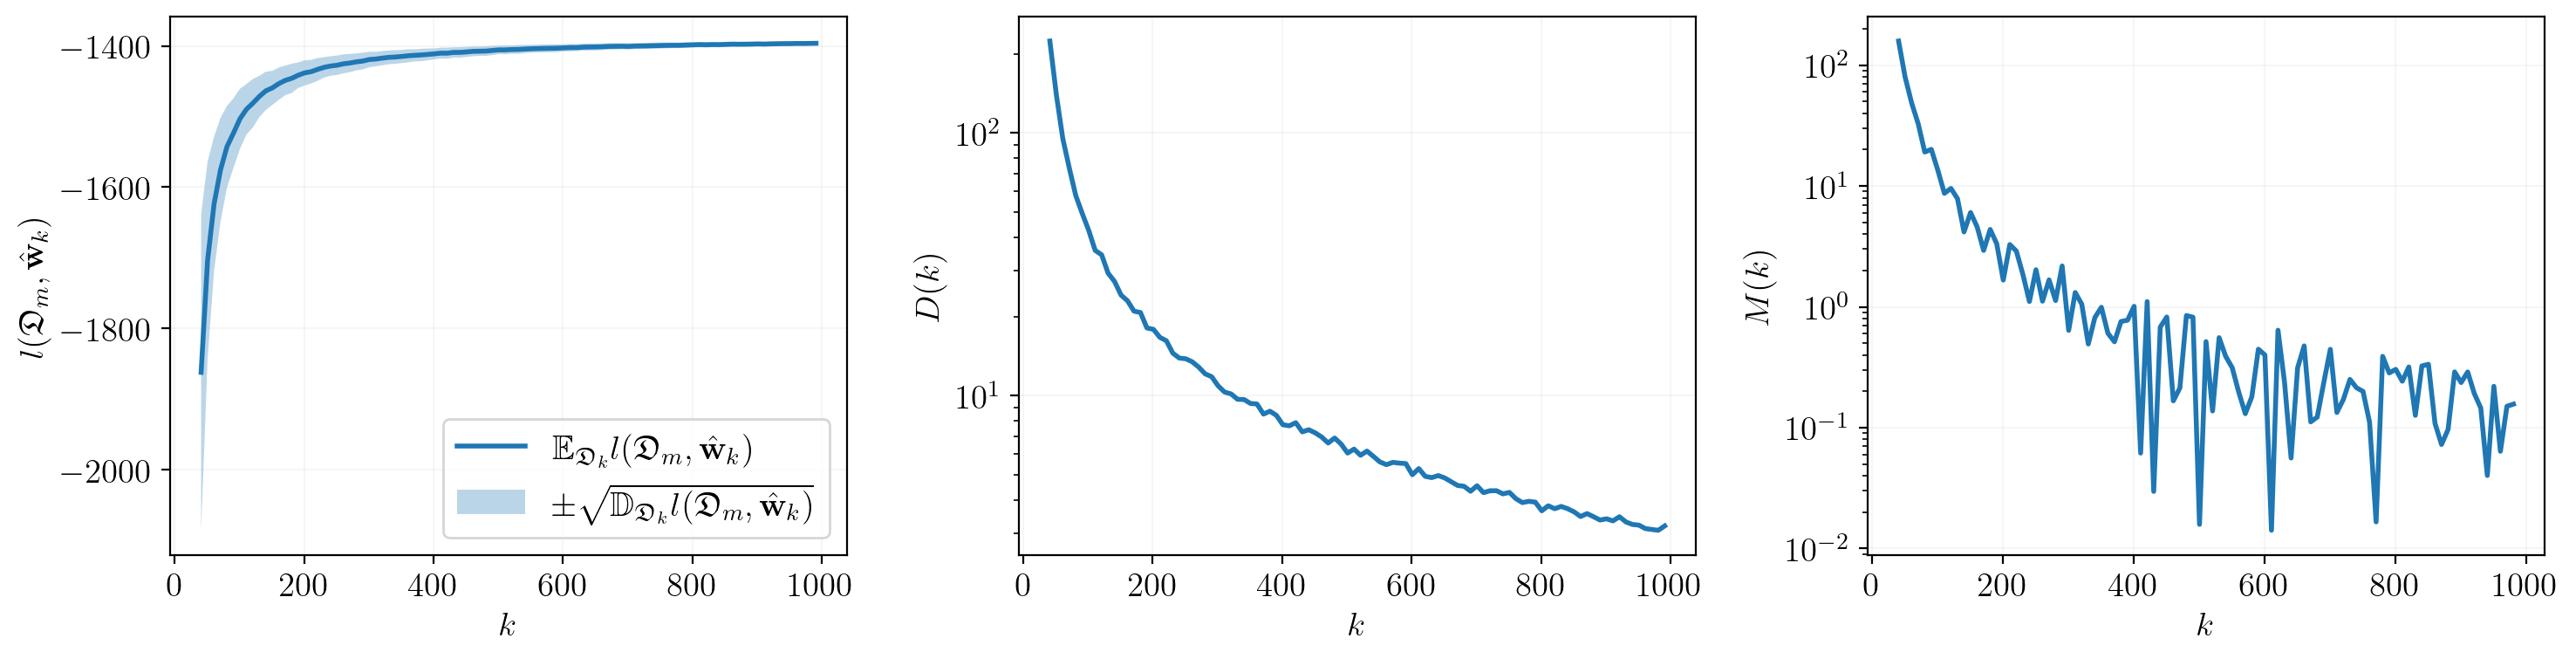

In [10]:
plot_bootstrap(sample_sizes, llh_means, llh_vars, save=False, filename="synthetic-regression.pdf")

In [11]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

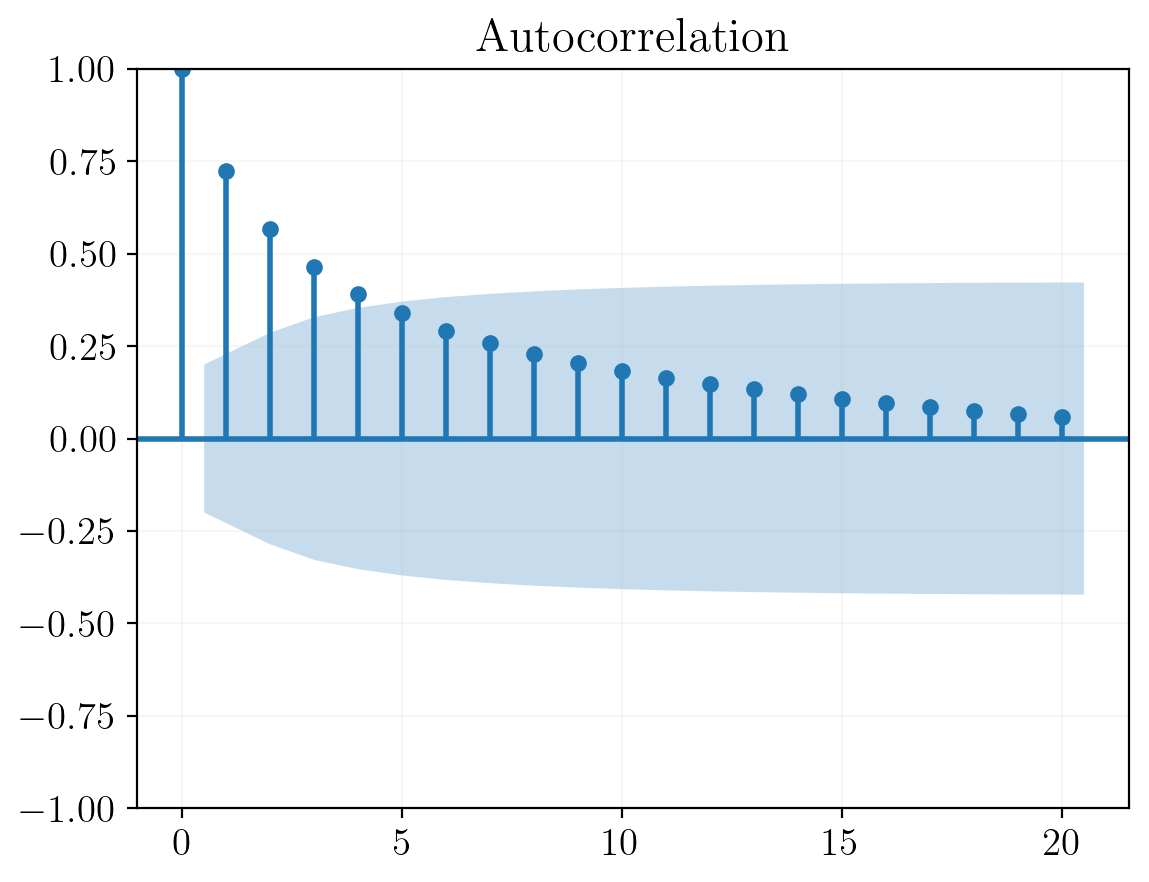

In [25]:
plot_acf(llh_means)
plt.show()

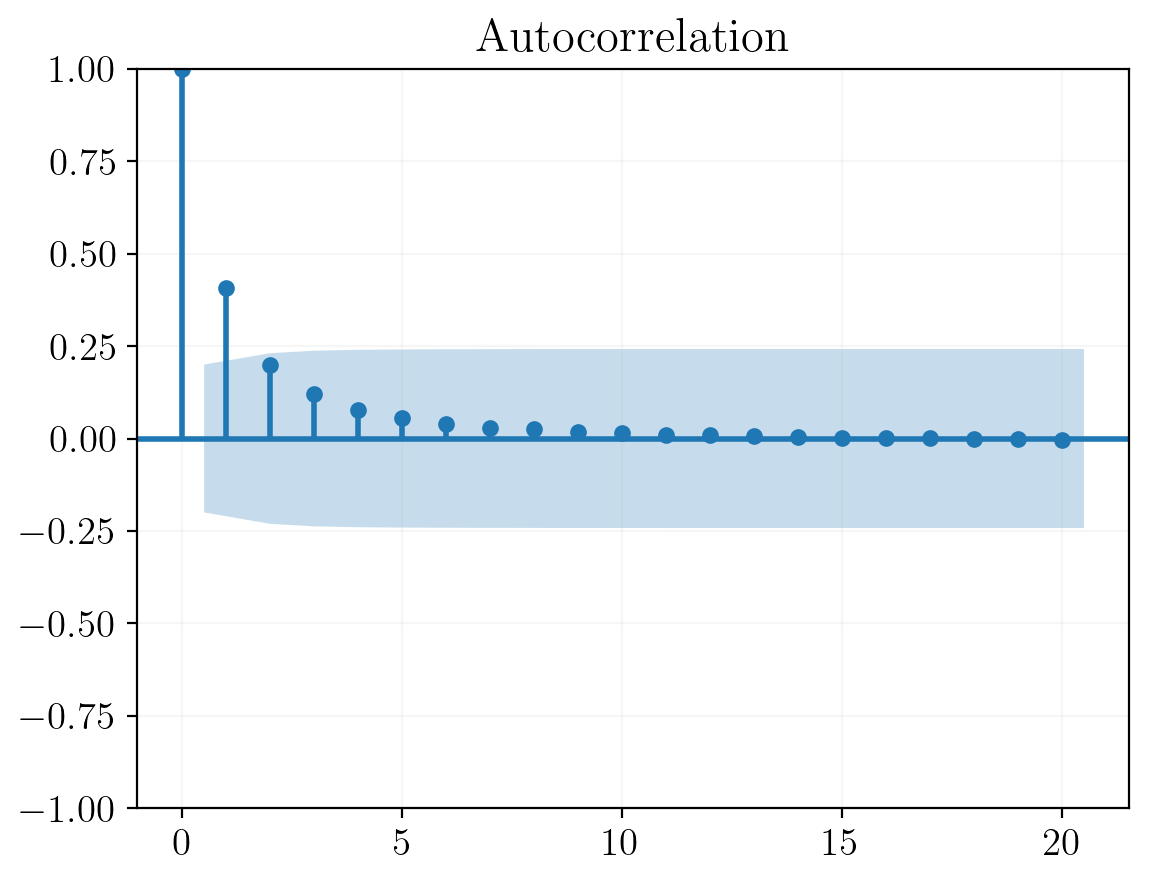

In [26]:
plot_acf(llh_vars)
plt.show()

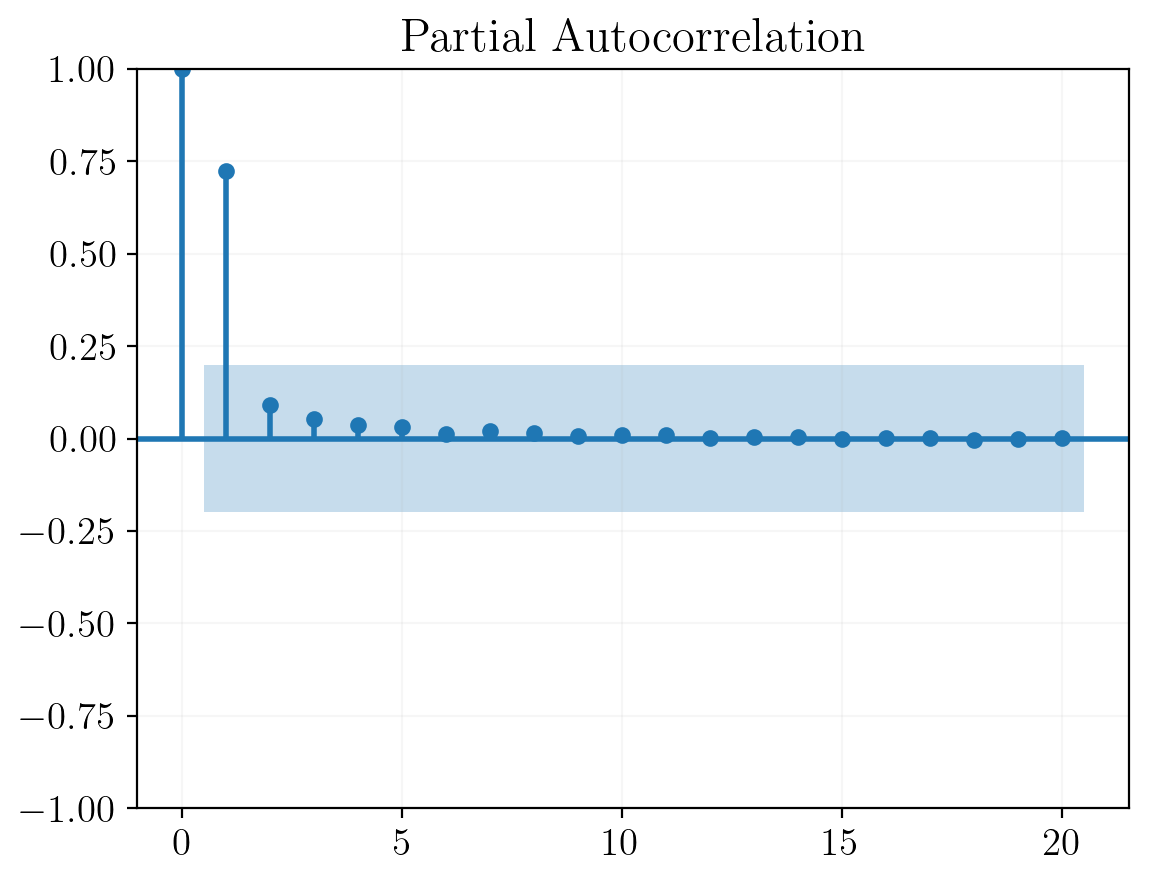

In [27]:
plot_pacf(llh_means)
plt.show()

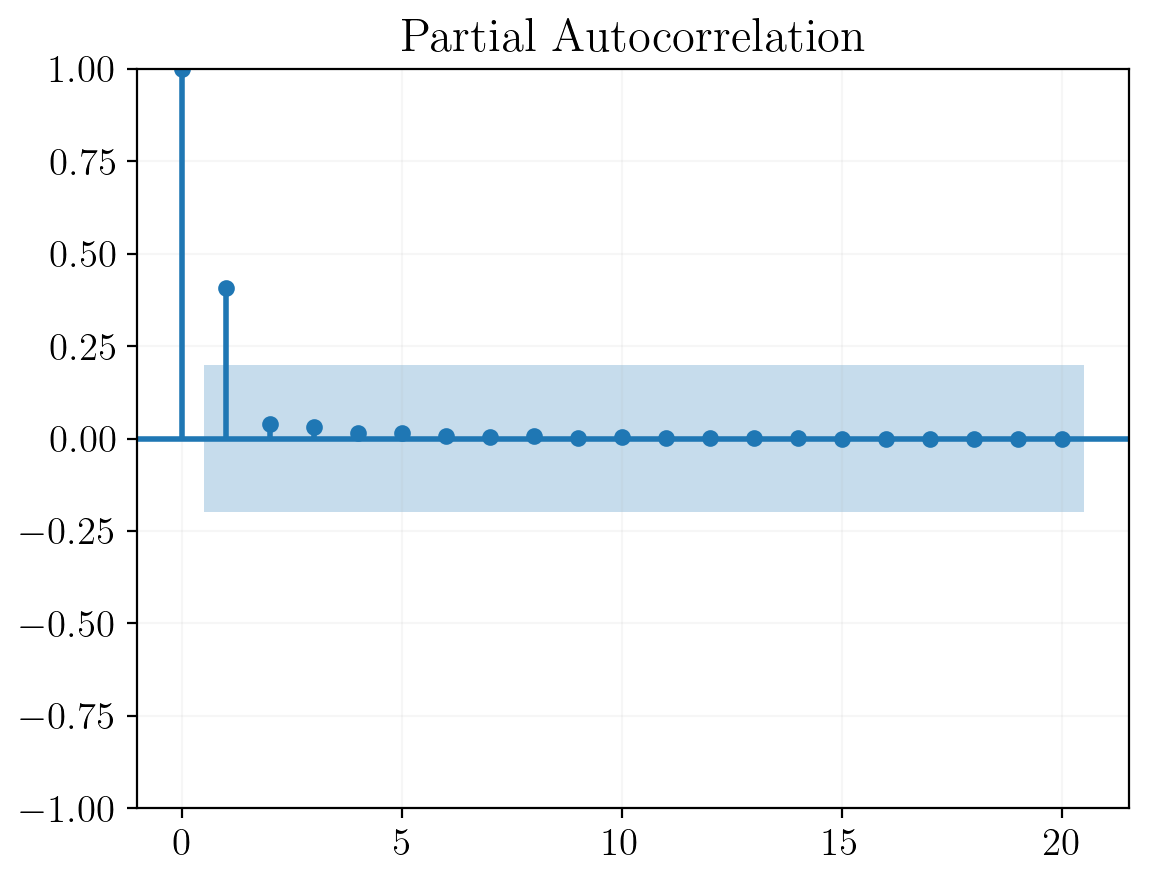

In [28]:
plot_pacf(llh_vars)
plt.show()

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose

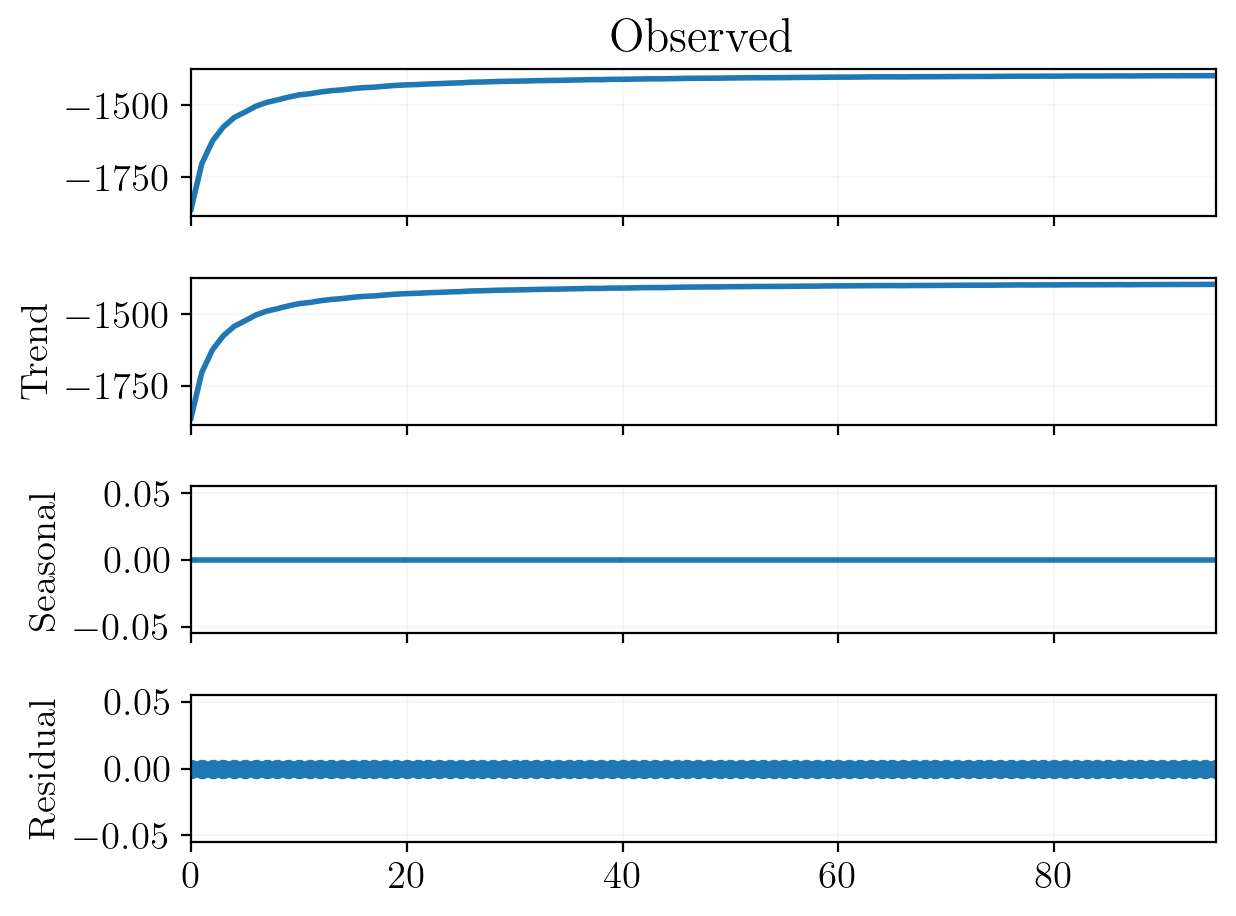

In [30]:
result = seasonal_decompose(llh_means, model='additive', period=1)
result.plot()
plt.show()

In [31]:
from statsmodels.tsa.arima.model import ARIMA

In [43]:
means_train = llh_means[:int(0.2*len(llh_means))]
means_test = llh_means[int(0.2*len(llh_means)):]

vars_train = llh_vars[:int(0.2*len(llh_vars))]
vars_test = llh_vars[int(0.2*len(llh_vars)):]

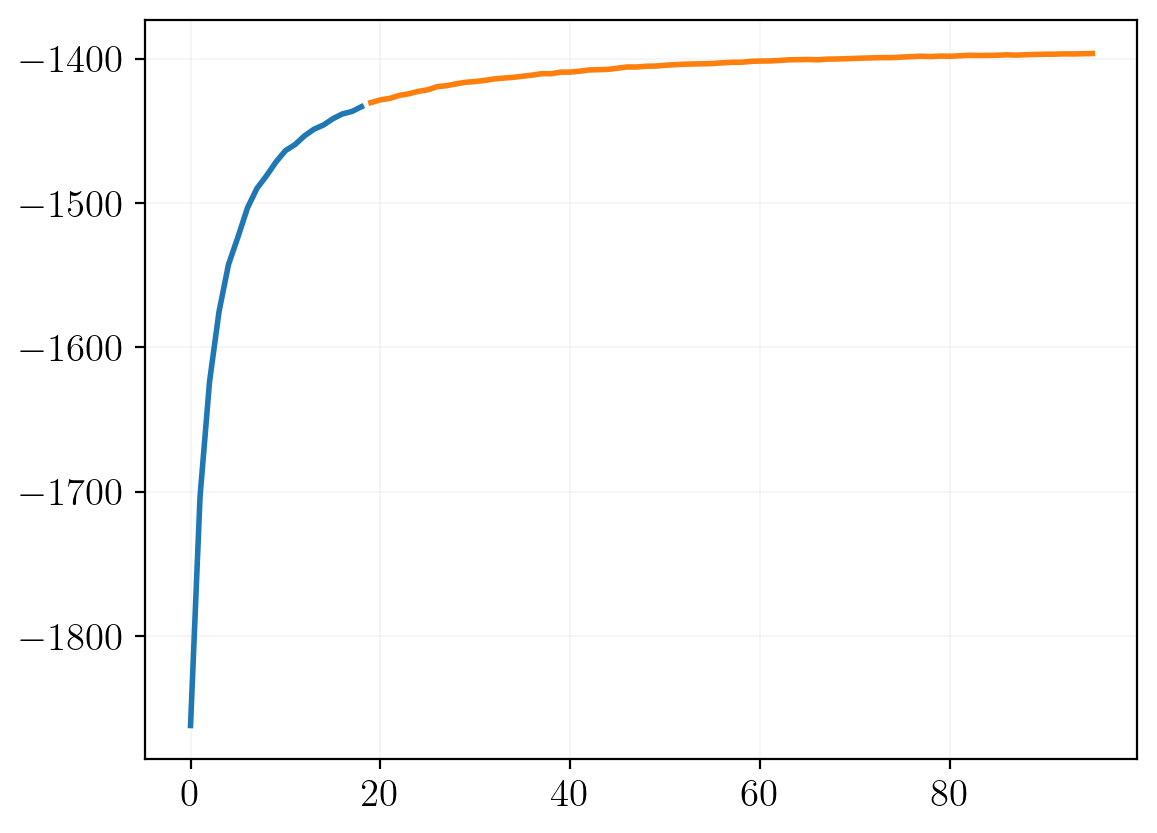

In [44]:
plt.plot(np.arange(len(means_train)), means_train)
plt.plot(np.arange(len(means_train), len(means_train) + len(means_test)), means_test)
plt.show()

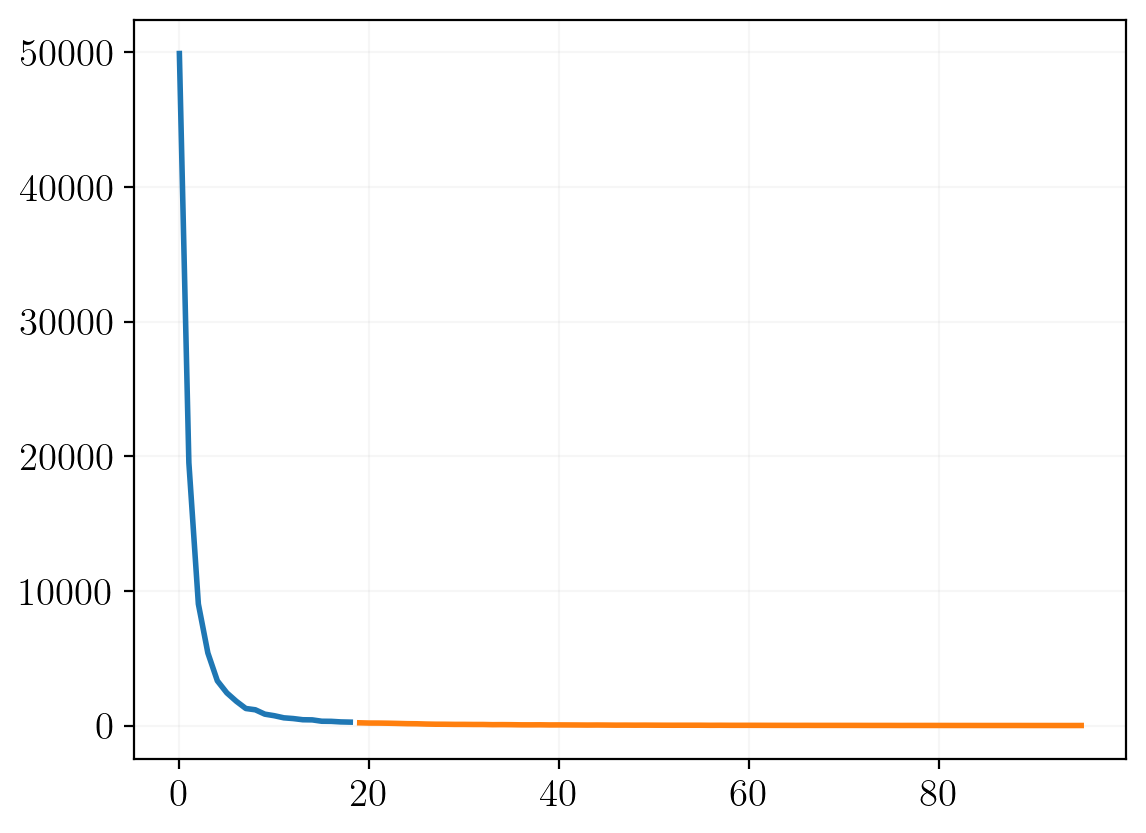

In [45]:
plt.plot(np.arange(len(vars_train)), vars_train)
plt.plot(np.arange(len(vars_train), len(vars_train) + len(vars_test)), vars_test)
plt.show()

In [46]:
model = ARIMA(means_train, order=(5, 0, 3))
res = model.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   19
Model:                 ARIMA(5, 0, 3)   Log Likelihood                 -81.777
Date:                Fri, 15 Dec 2023   AIC                            183.554
Time:                        10:33:33   BIC                            192.998
Sample:                             0   HQIC                           185.152
                                 - 19                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1515.7125   4916.690     -0.308      0.758   -1.12e+04    8120.824
ar.L1          1.9756      1.256      1.573      0.116      -0.486       4.437
ar.L2         -1.1081      2.747     -0.403      0.6

/Users/kisnikser/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/kisnikser/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/kisnikser/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


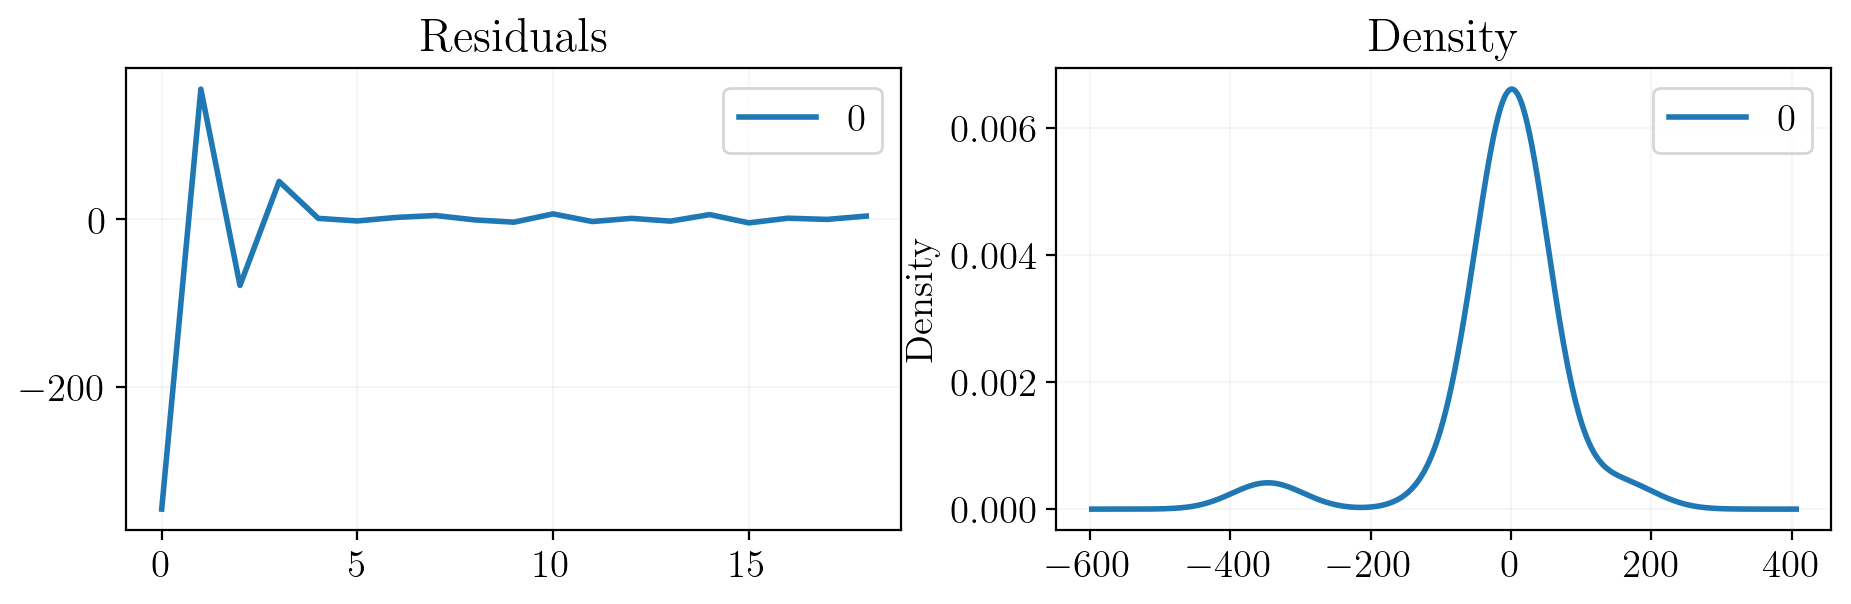

In [47]:
residuals = pd.DataFrame(res.resid)
fig, ax = plt.subplots(1, 2, figsize=(11, 3))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

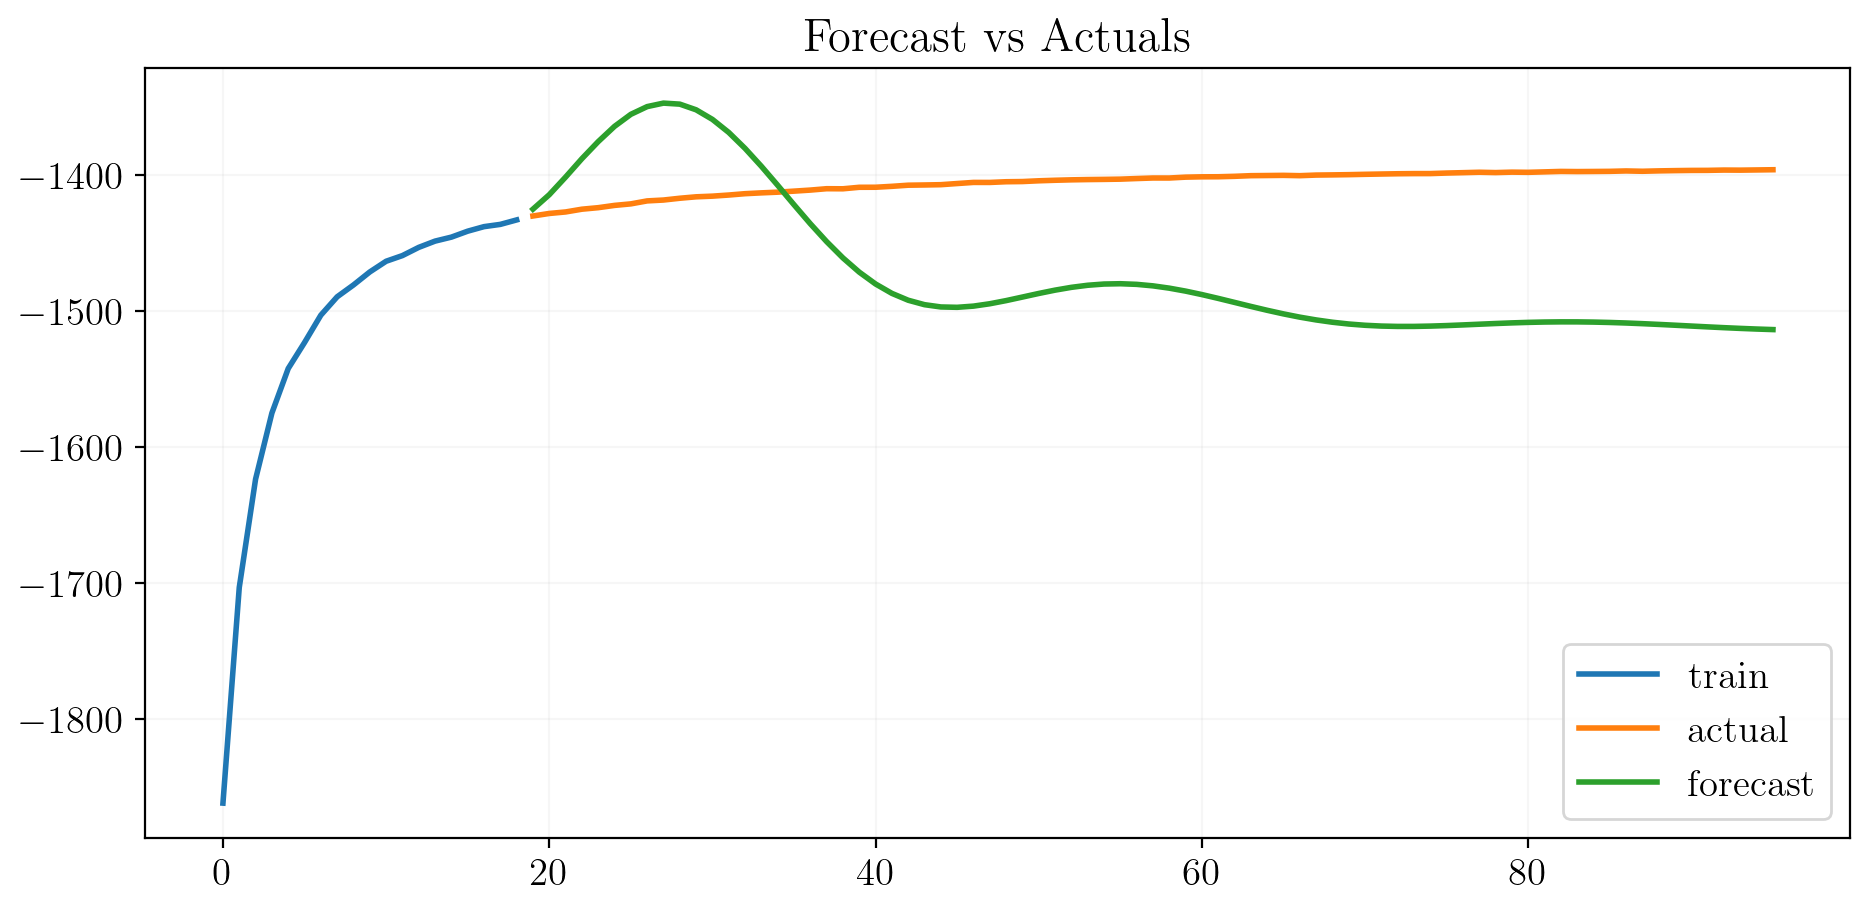

In [48]:
# Forecast
fc = res.get_forecast(len(means_test)).summary_frame()

# Plot
plt.figure(figsize=(11, 5))
plt.plot(np.arange(len(means_train)), means_train, label='train')
plt.plot(np.arange(len(means_train), len(means_train) + len(means_test)), means_test, label='actual')
plt.plot(np.arange(len(means_train), len(means_train) + len(means_test)), fc['mean'], label='forecast')
#plt.fill_between(np.arange(len(train), len(train) + len(test)), fc['mean_ci_lower'], fc['mean_ci_upper'], color='k', alpha=0.1)
plt.title('Forecast vs Actuals')
plt.legend()
plt.show()

In [49]:
model = ARIMA(vars_train, order=(5, 0, 3))
res = model.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   19
Model:                 ARIMA(5, 0, 3)   Log Likelihood                   0.000
Date:                Fri, 15 Dec 2023   AIC                             20.000
Time:                        10:34:07   BIC                             29.444
Sample:                             0   HQIC                            21.598
                                 - 19                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5192.1409         -0       -inf      0.000    5192.141    5192.141
ar.L1          2.9493   5.03e-08   5.87e+07      0.000       2.949       2.949
ar.L2         -1.9492        nan        nan        n

/Users/kisnikser/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/kisnikser/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/kisnikser/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kisnikser/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/mlemodel.py:3015: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse
/Users/kisnikser/anaconda3/lib/python3.11/site-packages/statsmode

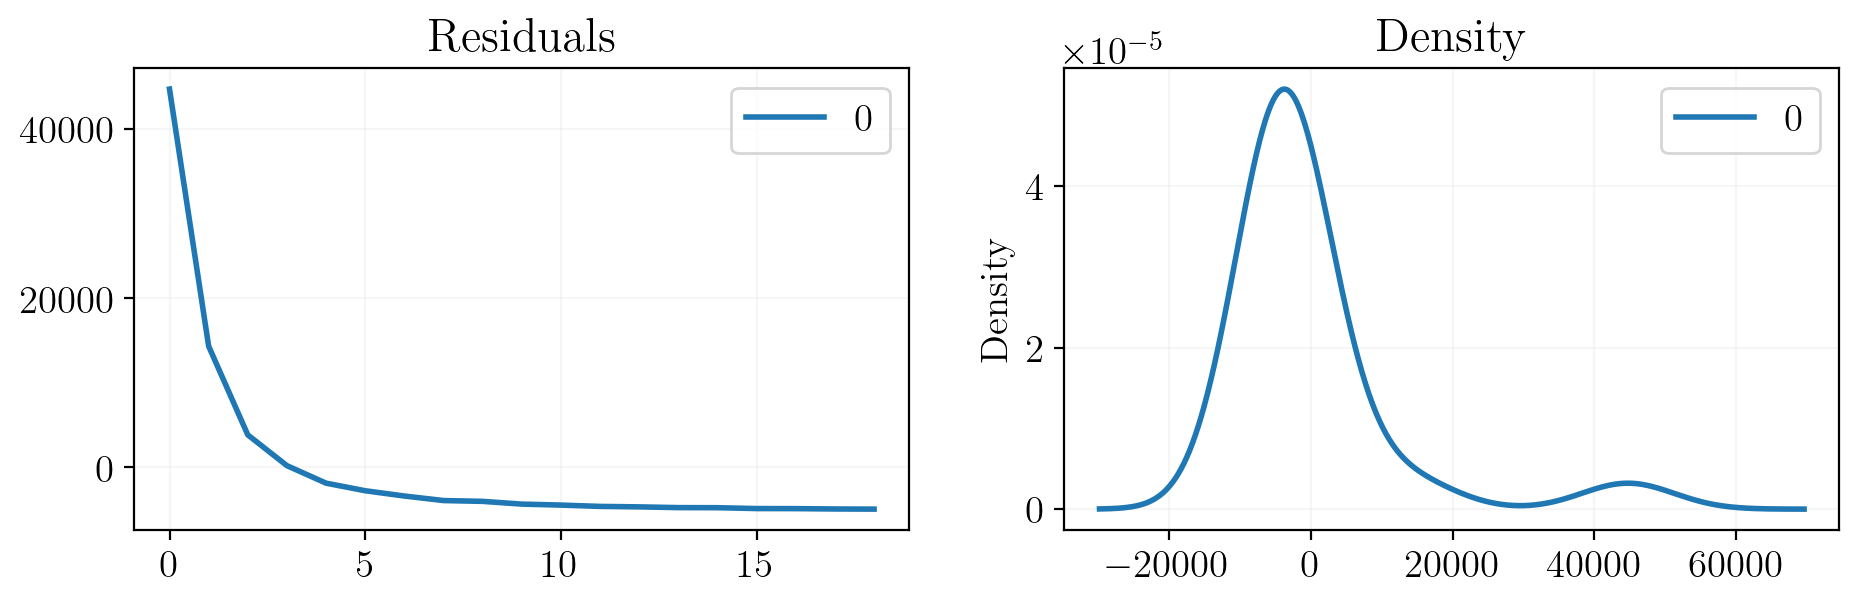

In [50]:
residuals = pd.DataFrame(res.resid)
fig, ax = plt.subplots(1, 2, figsize=(11, 3))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

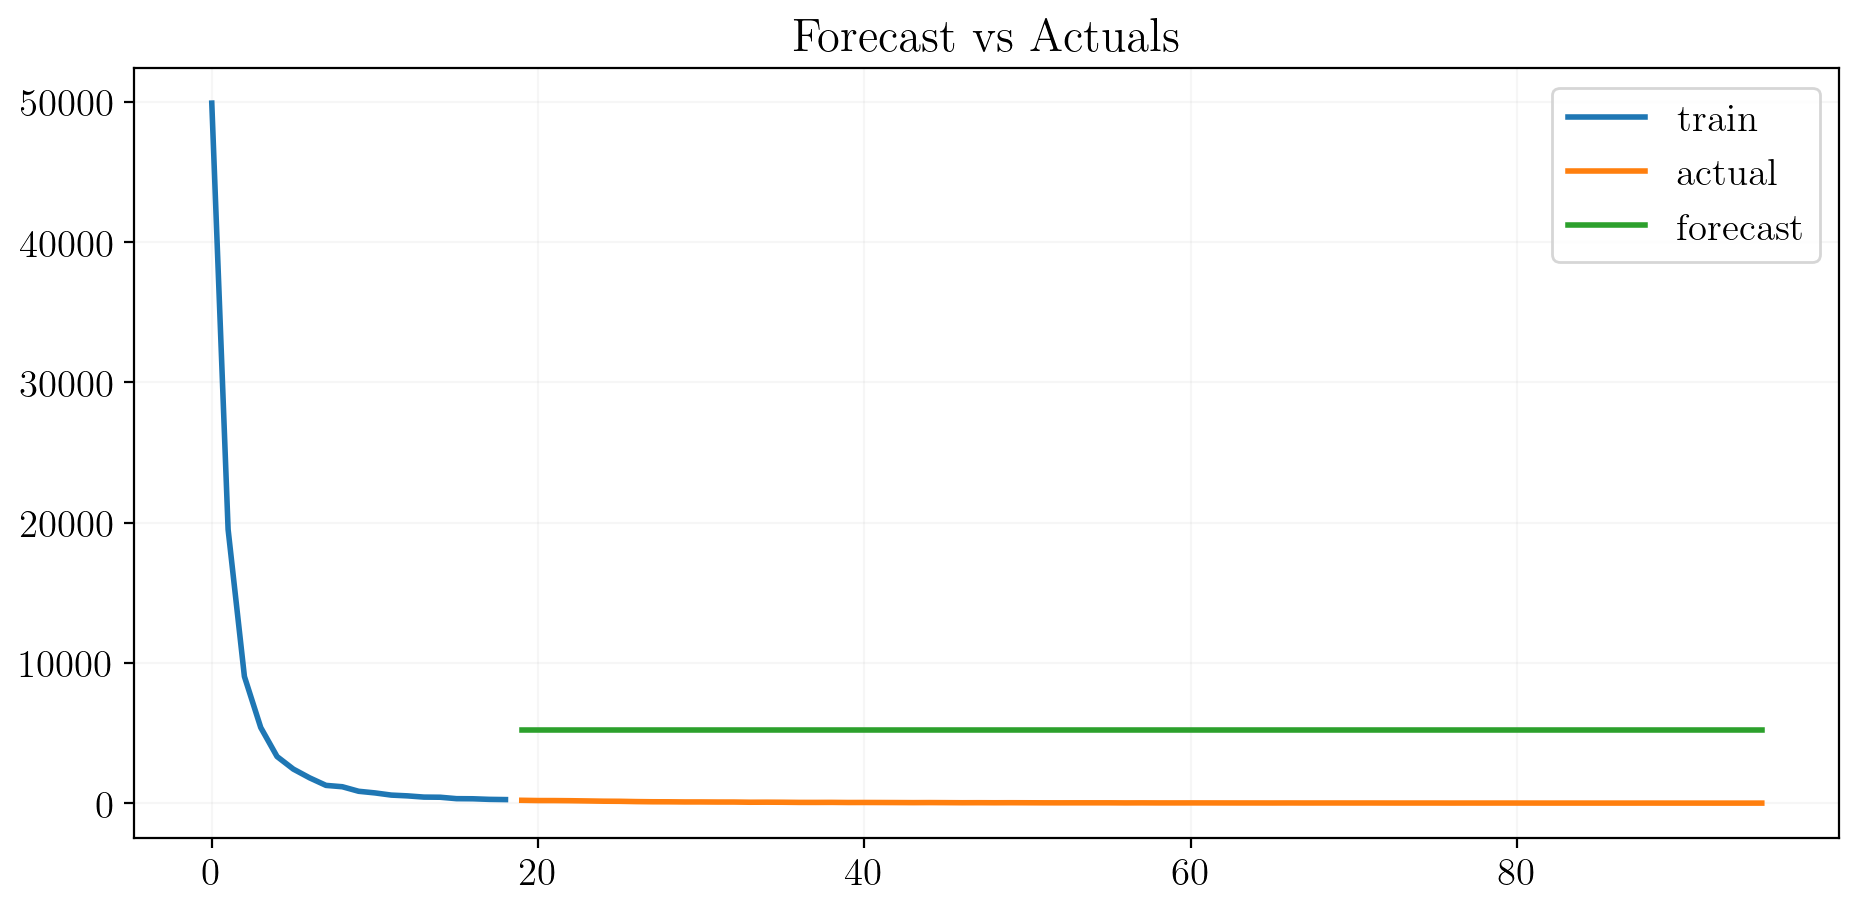

In [51]:
# Forecast
fc = res.get_forecast(len(vars_test)).summary_frame()

# Plot
plt.figure(figsize=(11, 5))
plt.plot(np.arange(len(vars_train)), vars_train, label='train')
plt.plot(np.arange(len(vars_train), len(vars_train) + len(vars_test)), vars_test, label='actual')
plt.plot(np.arange(len(vars_train), len(vars_train) + len(vars_test)), fc['mean'], label='forecast')
#plt.fill_between(np.arange(len(train), len(train) + len(test)), fc['mean_ci_lower'], fc['mean_ci_upper'], color='k', alpha=0.1)
plt.title('Forecast vs Actuals')
plt.legend()
plt.show()

In [74]:
from sklearn.neural_network import MLPRegressor

In [96]:
mlp = MLPRegressor(activation='logistic')

In [105]:
length = int(0.7*len(sample_sizes))

In [106]:
mlp.fit(sample_sizes[:length].reshape(-1, 1), llh_means[:length])

/Users/kisnikser/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(activation='logistic')

In [107]:
train_predicted = mlp.predict(sample_sizes[:length].reshape(-1, 1))
test_predicted = mlp.predict(sample_sizes[length:].reshape(-1, 1))

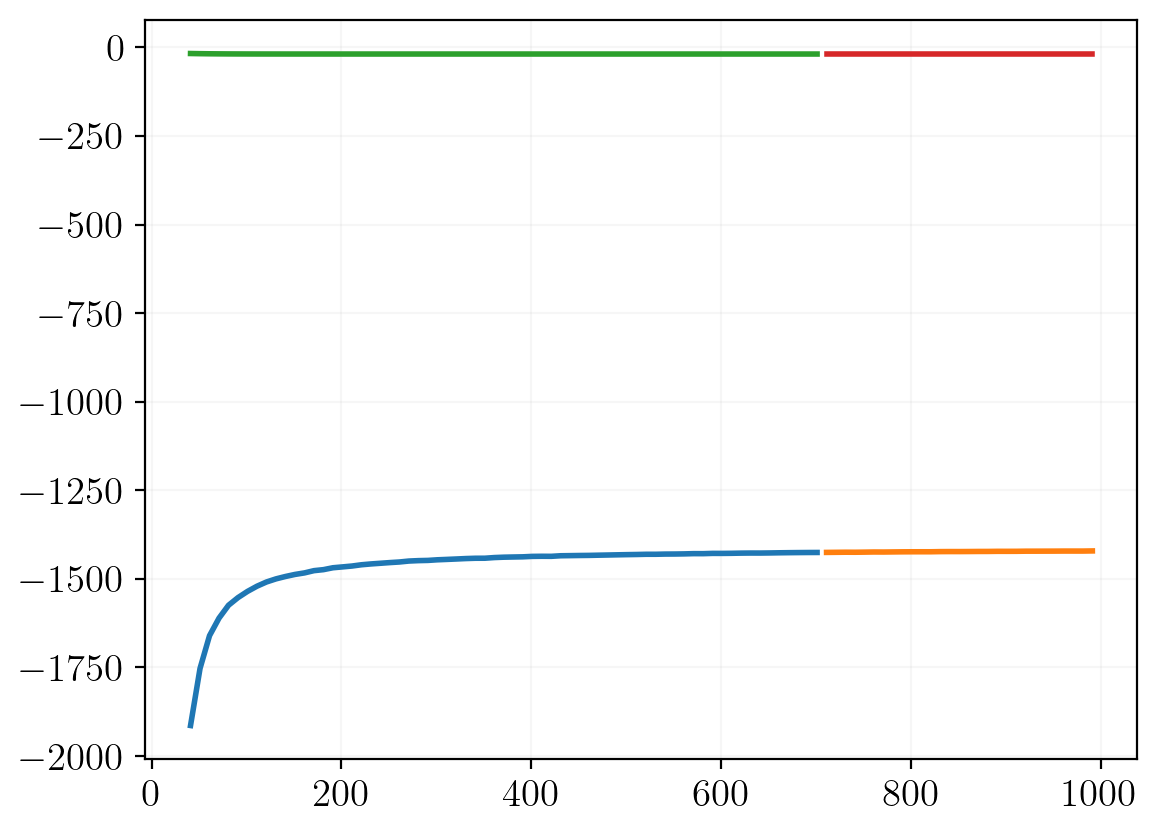

In [108]:
plt.plot(sample_sizes[:length], llh_means[:length])
plt.plot(sample_sizes[length:], llh_means[length:])
plt.plot(sample_sizes[:length], train_predicted)
plt.plot(sample_sizes[length:], test_predicted)

## Достаточный размер выборки не превосходит доступный

In [483]:
def sufficient_sample_size(sample_sizes, means, variances, eps=1e-4, method="variance"):
    
    m_star = np.inf
    
    if method == "variance":
        for k, var in zip(sample_sizes, D(means, variances)):
            if var <= eps and m_star == np.inf:
                m_star = k
            elif var > eps:
                m_star = np.inf
                
    elif method == "rate":
        for k, diff in zip(sample_sizes[:-1], M(means, variances)):
            if diff <= eps and m_star == np.inf:
                m_star = k
            elif diff > eps:
                m_star = np.inf
        
    return m_star

In [484]:
def plot_bootstrap_sufficient(sample_sizes, means, variances, eps_variance=1e2, eps_rate=1e0, save=False, filename="synthetic-regression-sufficient.pdf"):
    
    m_star_variance = sufficient_sample_size(sample_sizes, means, variances, eps=eps_variance, method="variance")
    m_star_rate = sufficient_sample_size(sample_sizes, means, variances, eps=eps_rate, method="rate")
    m_star_variance_idx = sample_sizes.tolist().index(m_star_variance)
    m_star_rate_idx = sample_sizes.tolist().index(m_star_rate)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
    
    stds = np.sqrt(variances)

    ax1.plot(sample_sizes, means, label=r"$\mathbb{E}_{\mathfrak{D}_k} l(\mathfrak{D}_m, \hat{\mathbf{w}}_k)$")
    ax1.fill_between(sample_sizes, means - stds, means + stds, alpha=0.3, label=r"$\pm \sqrt{\mathbb{D}_{\mathfrak{D}_k} l(\mathfrak{D}_m, \hat{\mathbf{w}}_k)}$")
    ax1.vlines(m_star_variance, min(means - stds), means[m_star_variance_idx], colors='red', linestyle='dashed', linewidth=1)
    ax1.scatter(m_star_variance, means[m_star_variance_idx], marker='o', color='red')
    ax1.vlines(m_star_rate, min(means - stds), means[m_star_rate_idx], colors='green', linestyle='dashed', linewidth=1)
    ax1.scatter(m_star_rate, means[m_star_rate_idx], marker='o', color='green')
    ax1.set_xlabel(r"$k$")
    ax1.set_ylabel(r"$l(\mathfrak{D}_m, \hat{\mathbf{w}}_k)$")
    ax1.legend(loc="lower right")

    ax2.plot(sample_sizes, D(means, stds))
    ax2.vlines(m_star_variance, 0, D(means, stds)[m_star_variance_idx], colors='red', linestyle='dashed', linewidth=1)
    ax2.scatter(m_star_variance, D(means, stds)[m_star_variance_idx], marker='o', color='red', label=f"D-sufficient ($\\varepsilon={eps_variance:.1e}$)")
    ax2.vlines(m_star_rate, 0, D(means, stds)[m_star_rate_idx], colors='green', linestyle='dashed', linewidth=1)
    ax2.scatter(m_star_rate, D(means, stds)[m_star_rate_idx], marker='o', color='green')
    ax2.set_xlabel(r"$k$")
    ax2.set_ylabel(r"$D(k)$")
    ax2.set_yscale('log')
    ax2.legend(loc="upper right")

    ax3.plot(sample_sizes[:-1], M(means, stds))
    ax3.vlines(m_star_variance, 0, M(means, stds)[m_star_variance_idx], colors='red', linestyle='dashed', linewidth=1)
    ax3.scatter(m_star_variance, M(means, stds)[m_star_variance_idx], marker='o', color='red')
    ax3.vlines(m_star_rate, 0, M(means, stds)[m_star_rate_idx], colors='green', linestyle='dashed', linewidth=1)
    ax3.scatter(m_star_rate, M(means, stds)[m_star_rate_idx], marker='o', color='green', label=f"M-sufficient ($\\varepsilon={eps_rate:.1e}$)")
    ax3.set_xlabel(r"$k$")
    ax3.set_ylabel(r"$M(k)$")
    ax3.set_yscale('log')
    ax3.legend(loc="upper right")

    plt.tight_layout()
    if save:
        plt.savefig(filename)
    plt.show()

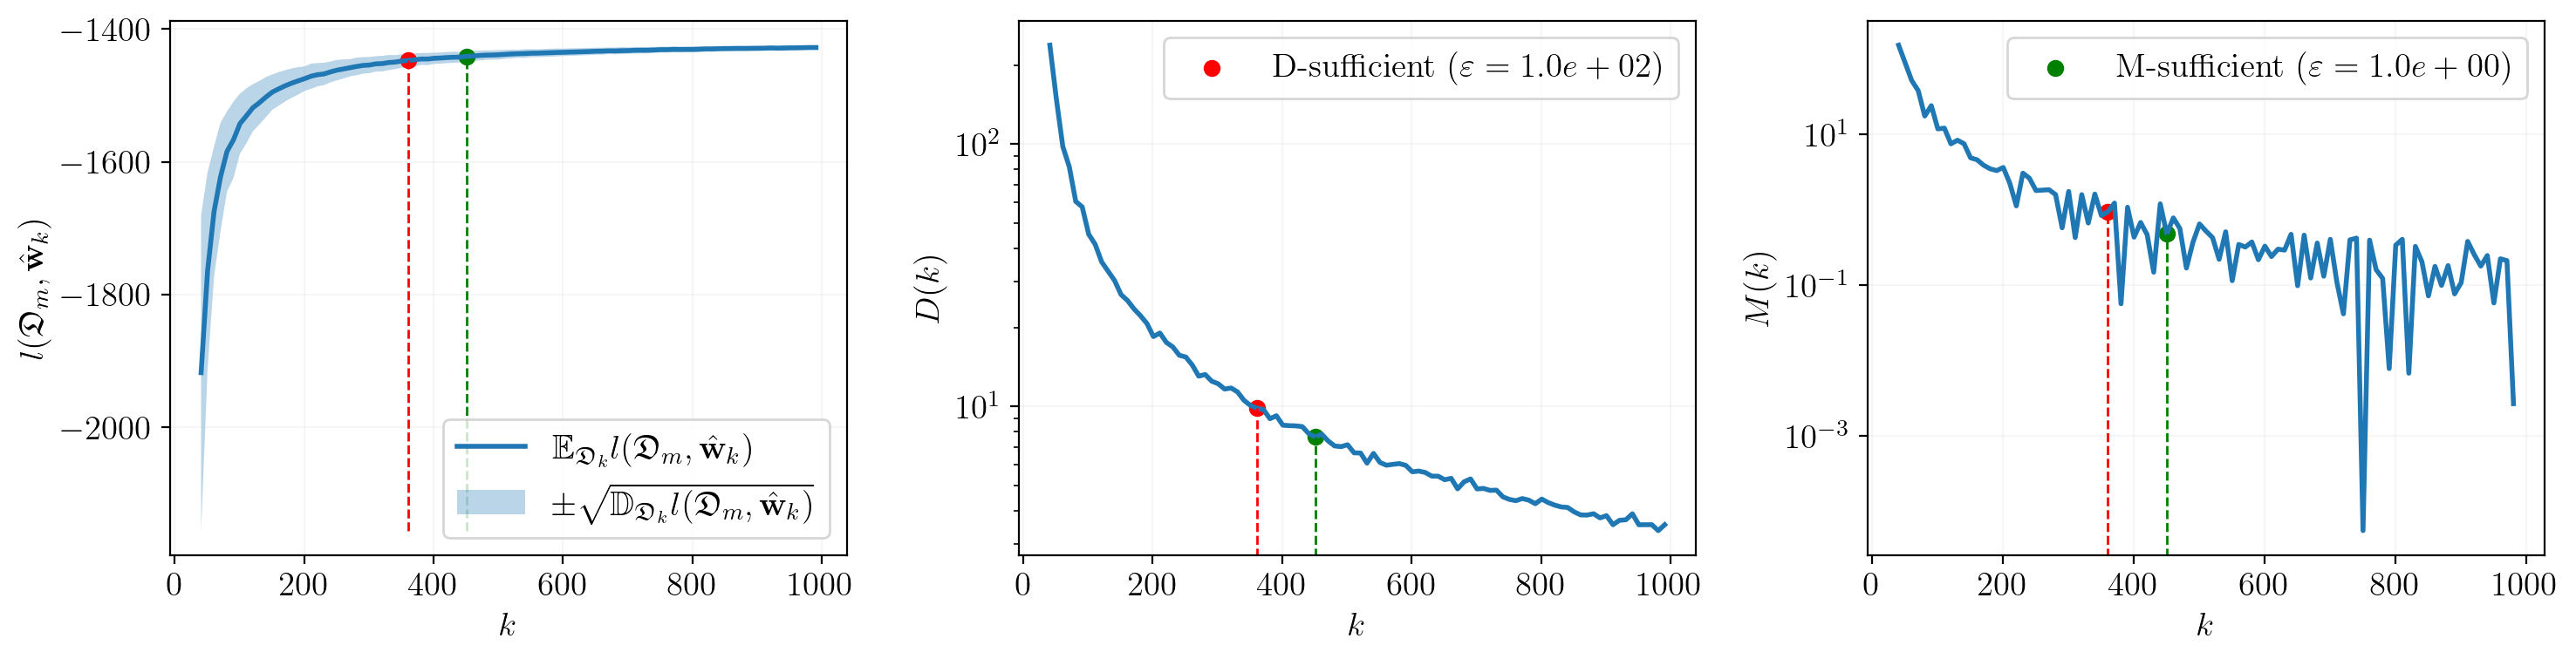

In [485]:
plot_bootstrap_sufficient(sample_sizes, llh_means, llh_vars, eps_variance=1e2, eps_rate=1e0, save=False, filename="synthetic-regression-sufficient.pdf")

## Достаточный размер выборки больше доступного

1. Аппроксимация среднего значения
$$ \mathrm{mean}(m) \approx w_0 - w_1^2 \cdot \exp\left( -w_2^2 \cdot m \right) - \dfrac{w_3^2}{m^{3/2}}$$

In [486]:
def func_mean_approx(m, w):
    return w[0] - (w[1]**2)*np.exp(-(w[2]**2)*m) - (w[3]**2)/(m**1.5)

2. Аппроксимация дисперсии

$$ \mathrm{var}(m) \approx w_0^2 \cdot \exp\left( - w_1^2 \cdot m \right) + \dfrac{w_2^2}{m^{3/2}} $$

In [487]:
def func_var_approx(m, w):
    return (w[0]**2)*np.exp(-(w[1]**2)*m)+(w[2]**2)/(m**1.5)

In [488]:
def approx(sample_sizes, sample_sizes_approximation, means, variances, func_mean=func_mean_approx, func_var=func_var_approx, n_means=4, n_vars=3, w0_means=None, w0_vars=None, train_size=0.7, verbose=False):

    # initial point for optimizing parameters w
    w0_means = np.random.normal(size=n_means) if w0_means is None else w0_means
    w0_vars = np.random.normal(size=n_vars) if w0_vars is None else w0_vars
    # number of points in train sample
    M = int(train_size*sample_sizes.size)
        
    X_train_means = sample_sizes[:M]
    y_train_means = means[:M]
    
    X_train_vars = sample_sizes[:M]
    y_train_vars = variances[:M]
        
    # find parameters w, that minimize MSE between log-likelihood (-loss) mean and it's approximation
    # start optimizing from w = w0
    # по сути просто идет аппроксимация одномерной функции на отрезке, тут ничего сложного
    means_minimum = minimize(lambda w: ((func_mean(X_train_means, w) - y_train_means)**2).sum(), w0_means)
    w_means = means_minimum.x
    vars_minimum = minimize(lambda w: ((func_var(X_train_vars, w) - y_train_vars)**2).sum(), w0_vars)
    w_vars = vars_minimum.x
    
    means_approximation = func_mean(sample_sizes_approximation, w_means)
    vars_approximation = func_var(sample_sizes_approximation, w_vars)

    return means_approximation, vars_approximation

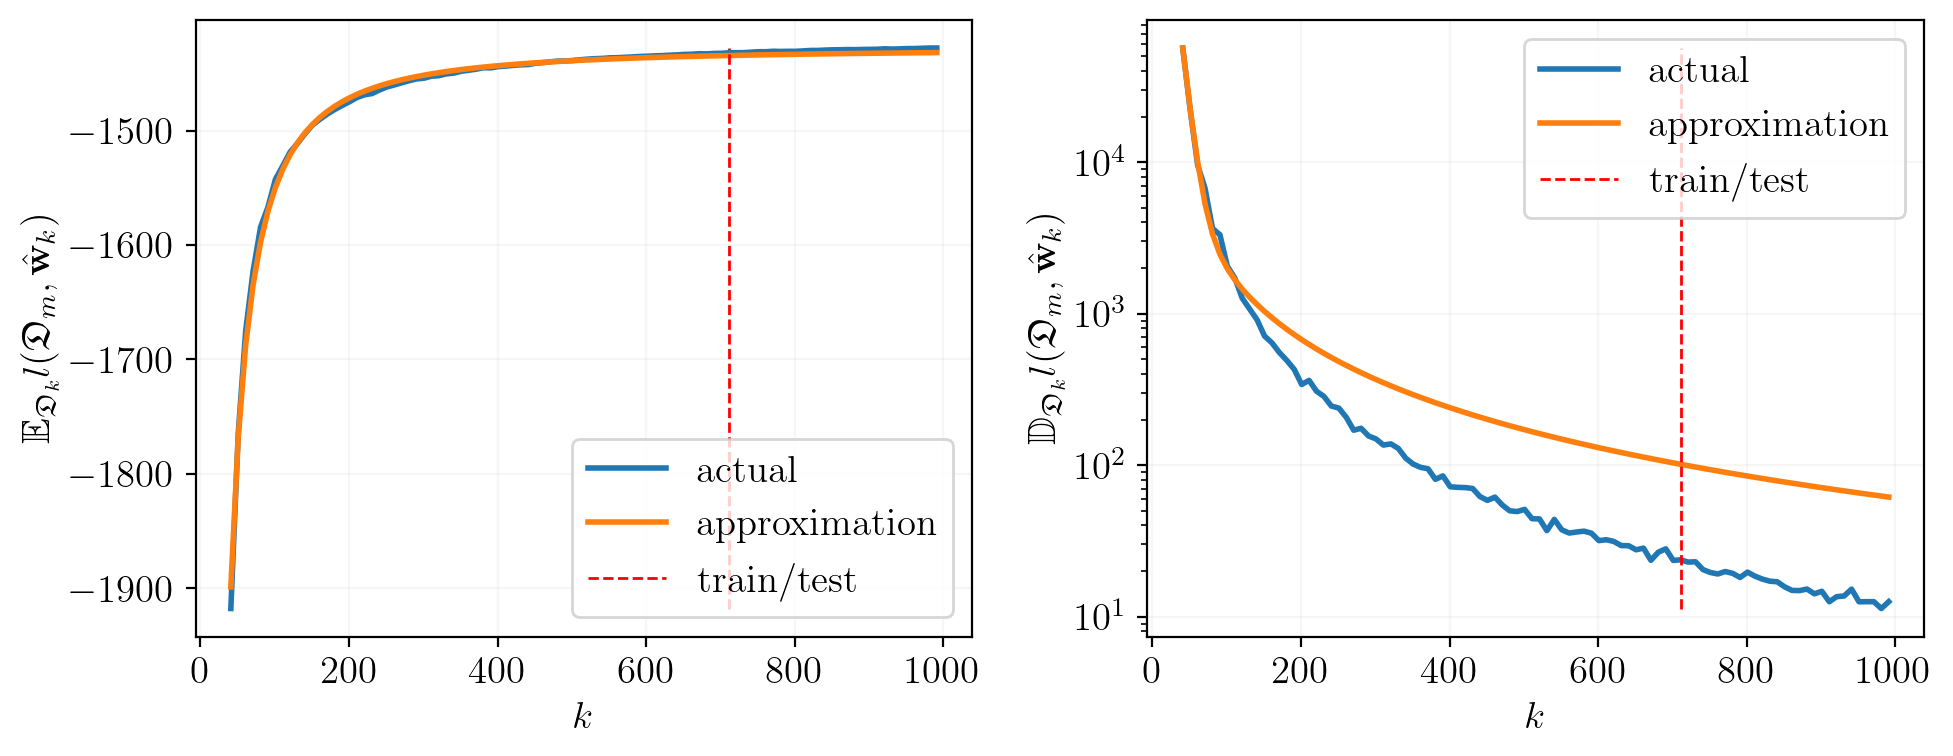

In [528]:
llh_means_approximation, llh_vars_approximation = approx(
    sample_sizes, sample_sizes, llh_means, llh_vars, func_mean_approx, func_var_approx
)

train_bound = int(0.7 * sample_sizes.size)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(sample_sizes, llh_means, label='actual')
ax1.plot(sample_sizes, llh_means_approximation, label='approximation')
ax1.vlines(sample_sizes[train_bound], min(llh_means), max(llh_means), colors='red', linestyle='dashed', linewidth=1, label='train/test')
ax1.legend()
ax1.set_xlabel(r"$k$")
ax1.set_ylabel(r"$\mathbb{E}_{\mathfrak{D}_k} l(\mathfrak{D}_m, \hat{\mathbf{w}}_k)$")

ax2.plot(sample_sizes, llh_vars, label='actual')
ax2.plot(sample_sizes, llh_vars_approximation, label='approximation')
ax2.vlines(sample_sizes[train_bound], min(llh_vars), max(llh_vars), colors='red', linestyle='dashed', linewidth=1, label='train/test')
ax2.legend()
ax2.set_xlabel(r"$k$")
ax2.set_ylabel(r"$\mathbb{D}_{\mathfrak{D}_k} l(\mathfrak{D}_m, \hat{\mathbf{w}}_k)$")
ax2.set_yscale('log')

plt.tight_layout()
plt.savefig("synthetic-regression-approximation.pdf")
plt.show()

In [529]:
def plot_bootstrap_sufficient_approximation(sample_sizes, means, means_approximation, variances, variances_approximation, eps_variance=1e2, eps_rate=1e0, save=False, filename="synthetic-regression-sufficient.pdf"):
    
    m_star_variance = sufficient_sample_size(sample_sizes, means_approximation, variances, eps=eps_variance, method="variance")
    m_star_rate = sufficient_sample_size(sample_sizes, means_approximation, variances, eps=eps_rate, method="rate")
    m_star_variance_idx = sample_sizes.tolist().index(m_star_variance)
    m_star_rate_idx = sample_sizes.tolist().index(m_star_rate)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
    
    stds = np.sqrt(variances)
    stds_approximation = np.sqrt(variances_approximation)

    ax1.plot(sample_sizes, means, label="actual")
    ax1.fill_between(sample_sizes, means - stds, means + stds, alpha=0.3)
    ax1.plot(sample_sizes, means_approximation, label="approximation")
    ax1.fill_between(sample_sizes, means_approximation - stds_approximation, means_approximation + stds_approximation, alpha=0.3)
    ax1.vlines(m_star_variance, min(means_approximation - stds_approximation), means_approximation[m_star_variance_idx], colors='red', linestyle='dashed', linewidth=1)
    ax1.scatter(m_star_variance, means_approximation[m_star_variance_idx], marker='o', color='red')
    ax1.vlines(m_star_rate, min(means_approximation - stds_approximation), means_approximation[m_star_rate_idx], colors='green', linestyle='dashed', linewidth=1)
    ax1.scatter(m_star_rate, means_approximation[m_star_rate_idx], marker='o', color='green')
    ax1.set_xlabel(r"$k$")
    ax1.set_ylabel(r"$l(\mathfrak{D}_m, \hat{\mathbf{w}}_k)$")
    ax1.legend(loc="lower right")

    ax2.plot(sample_sizes, D(means, stds), label="actual")
    ax2.plot(sample_sizes, D(means_approximation, stds_approximation), label="approximation")
    ax2.vlines(m_star_variance, 0, D(means_approximation, stds_approximation)[m_star_variance_idx], colors='red', linestyle='dashed', linewidth=1)
    ax2.scatter(m_star_variance, D(means_approximation, stds_approximation)[m_star_variance_idx], marker='o', color='red', label=f"D-sufficient ($\\varepsilon={eps_variance:.1e}$)")
    ax2.vlines(m_star_rate, 0, D(means_approximation, stds_approximation)[m_star_rate_idx], colors='green', linestyle='dashed', linewidth=1)
    ax2.scatter(m_star_rate, D(means_approximation, stds_approximation)[m_star_rate_idx], marker='o', color='green')
    ax2.set_xlabel(r"$k$")
    ax2.set_ylabel(r"$D(k)$")
    ax2.set_yscale('log')
    ax2.legend(loc="upper right")

    ax3.plot(sample_sizes[:-1], M(means, stds), label="actual")
    ax3.plot(sample_sizes[:-1], M(means_approximation, stds_approximation), label="approximation")
    ax3.vlines(m_star_variance, 0, M(means_approximation, stds_approximation)[m_star_variance_idx], colors='red', linestyle='dashed', linewidth=1)
    ax3.scatter(m_star_variance, M(means_approximation, stds_approximation)[m_star_variance_idx], marker='o', color='red')
    ax3.vlines(m_star_rate, 0, M(means_approximation, stds_approximation)[m_star_rate_idx], colors='green', linestyle='dashed', linewidth=1)
    ax3.scatter(m_star_rate, M(means_approximation, stds_approximation)[m_star_rate_idx], marker='o', color='green', label=f"M-sufficient ($\\varepsilon={eps_rate:.1e}$)")
    ax3.set_xlabel(r"$k$")
    ax3.set_ylabel(r"$M(k)$")
    ax3.set_yscale('log')
    ax3.legend(loc="upper right")

    plt.tight_layout()
    if save:
        plt.savefig(filename)
    plt.show()

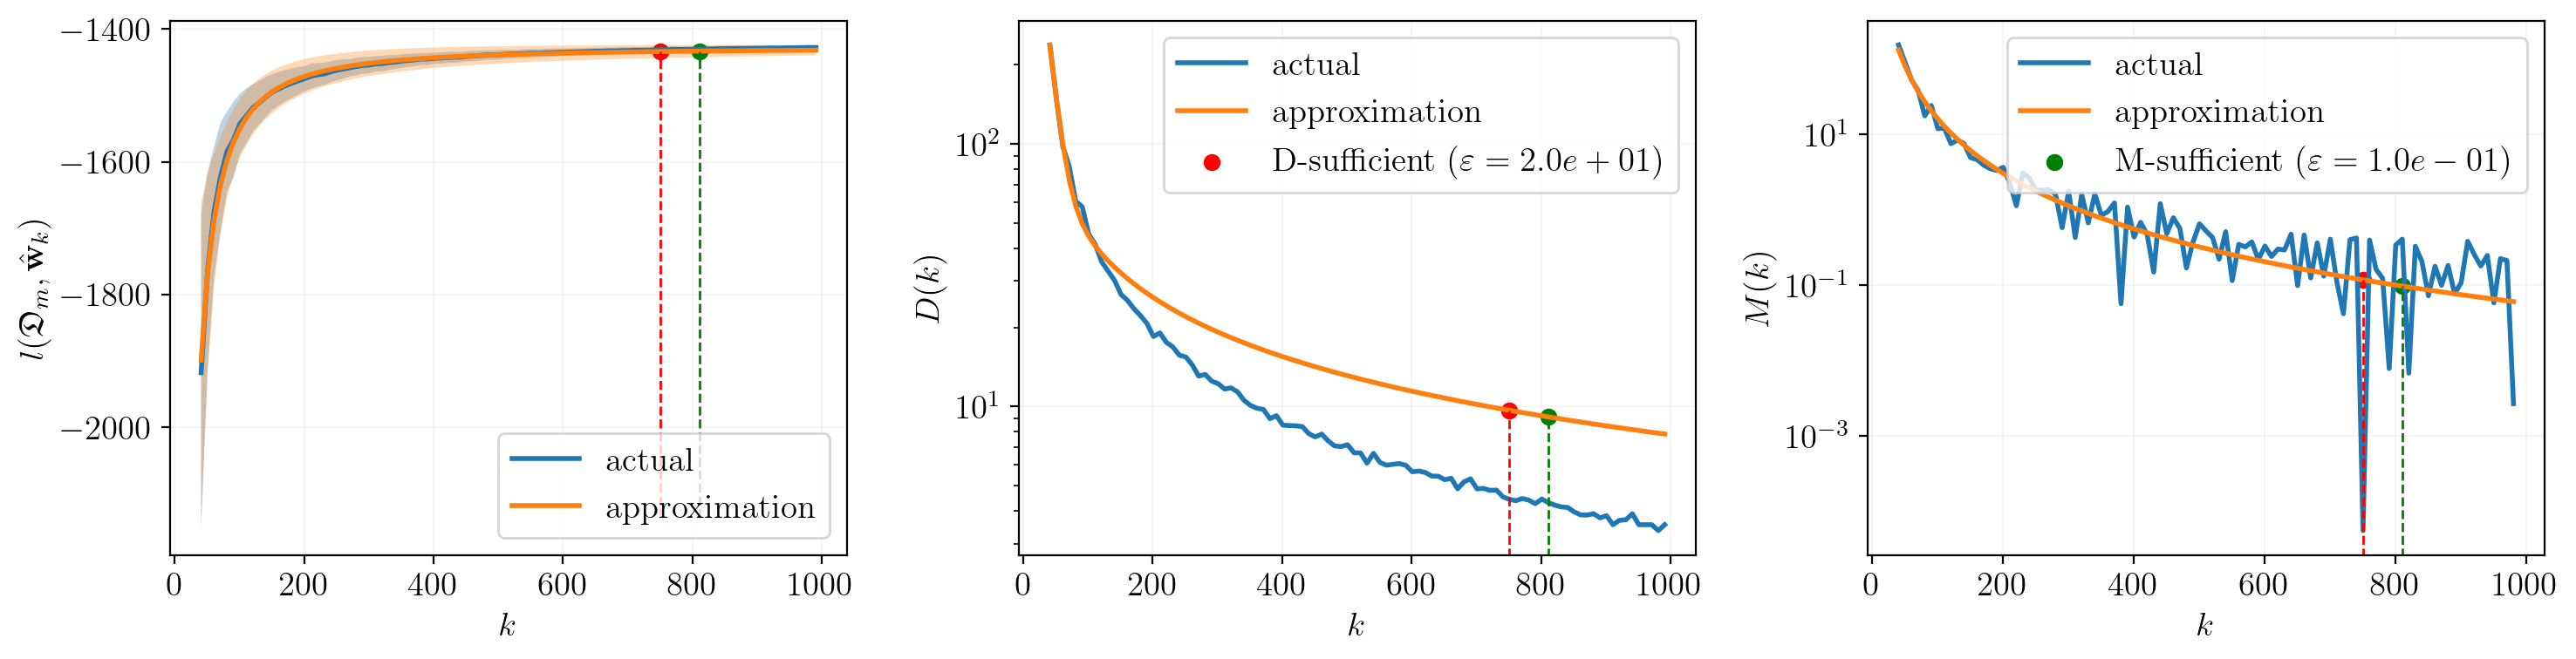

In [530]:
plot_bootstrap_sufficient_approximation(sample_sizes, llh_means, llh_means_approximation, llh_vars, llh_vars_approximation, eps_variance=2e1, eps_rate=1e-1, save=True, filename="synthetic-regression-approximation.pdf")

# Логистическая регрессия

$$ \mathbf{X} \in \mathbb{R}^{m \times n}, \qquad \mathbf{y} \in \mathbb{R}^{m}, \qquad \mathbf{w} \in \mathbb{R}^{n} $$

$$ p(\mathbf{y}, \mathbf{w}, \mathbf{X} | \alpha) = \prod_{i=1}^{m} \mathcal{N}(\mathbf{x}_i | \boldsymbol{\mu}, \mathbf{\Sigma}) \mathcal{N}(\mathbf{w} | \mathbf{0}, \alpha^{-1} \mathbf{I}_n) \prod_{i=1}^{m} p(y_i | \mathbf{x}_i, \mathbf{w}) $$

$$ p(y_i | \mathbf{x}_i, \mathbf{w}) = \sigma(y_i \mathbf{w}^\top \mathbf{x}_i) $$

Сгенерируем синтетическую выборку

In [531]:
def sigmoid(x):
    x = np.asarray(x)
    return 1 / (1 + np.exp(-x))

In [532]:
def likelihood(y, X, w):
    return np.prod(sigmoid(y * (X @ w)))

In [533]:
def loglikelihood(y, X, w):
    return np.sum(np.log(sigmoid(y * (X @ w))))

In [534]:
m = 1000
n = 20

mu = np.zeros(n)
Sigma = np.identity(n)

alpha = 1

In [535]:
X = sps.multivariate_normal(mean=mu, cov=Sigma).rvs(size=m)
w = sps.multivariate_normal(mean=np.zeros(n), cov=alpha**(-1)*np.identity(n)).rvs(size=1)
y = sps.bernoulli(p=sigmoid(X @ w)).rvs(size=m)
y[y == 0] = -1

In [536]:
dataset = Dataset(X, y)

С помощью техники бутстрэп сделаем оценку метематического ожидания и дисперсии

In [537]:
sample_sizes = np.arange(2*n, X.shape[0], 10)+1

In [538]:
B = 1000
llh_means = []
llh_vars = []
#loss_means = []
#loss_stds = []

for k in tqdm(sample_sizes):
    tmp = []
    tmp_loss = []
    for _ in range(B):
        X_k, y_k = dataset.sample(k)
        model = LogisticModel(X_k, y_k, alpha=alpha)
        w_hat = model.fit()
        tmp.append(loglikelihood(y, X, w_hat))
    tmp = np.array(tmp)
    #tmp_loss = np.array(tmp_loss)
    llh_means.append(tmp.mean())
    llh_vars.append(tmp.var())
    #loss_means.append(tmp_loss.mean())
    #loss_stds.append(tmp_loss.std())

llh_means = np.array(llh_means)
llh_vars = np.array(llh_vars)
#loss_means = np.array(loss_means)
#loss_stds = np.array(loss_stds)

  0%|          | 0/96 [00:00<?, ?it/s]

100%|██████████| 96/96 [02:57<00:00,  1.85s/it]


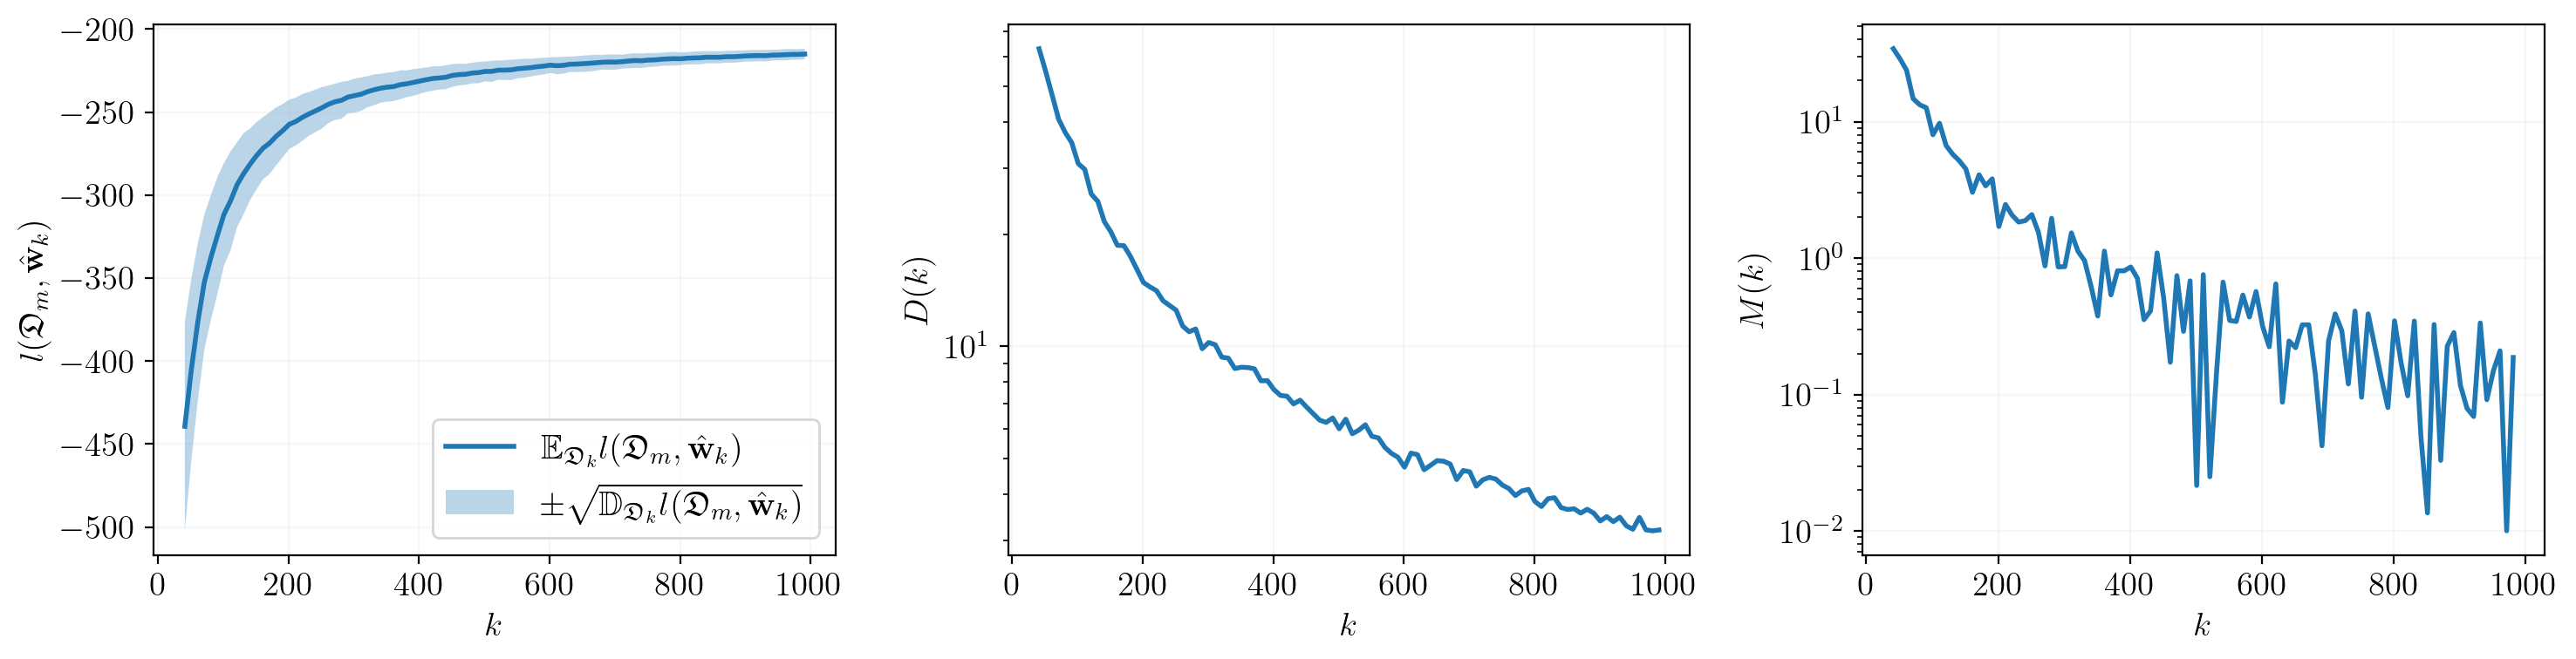

In [539]:
plot_bootstrap(sample_sizes, llh_means, llh_vars, save=False, filename="synthetic-classification.pdf")

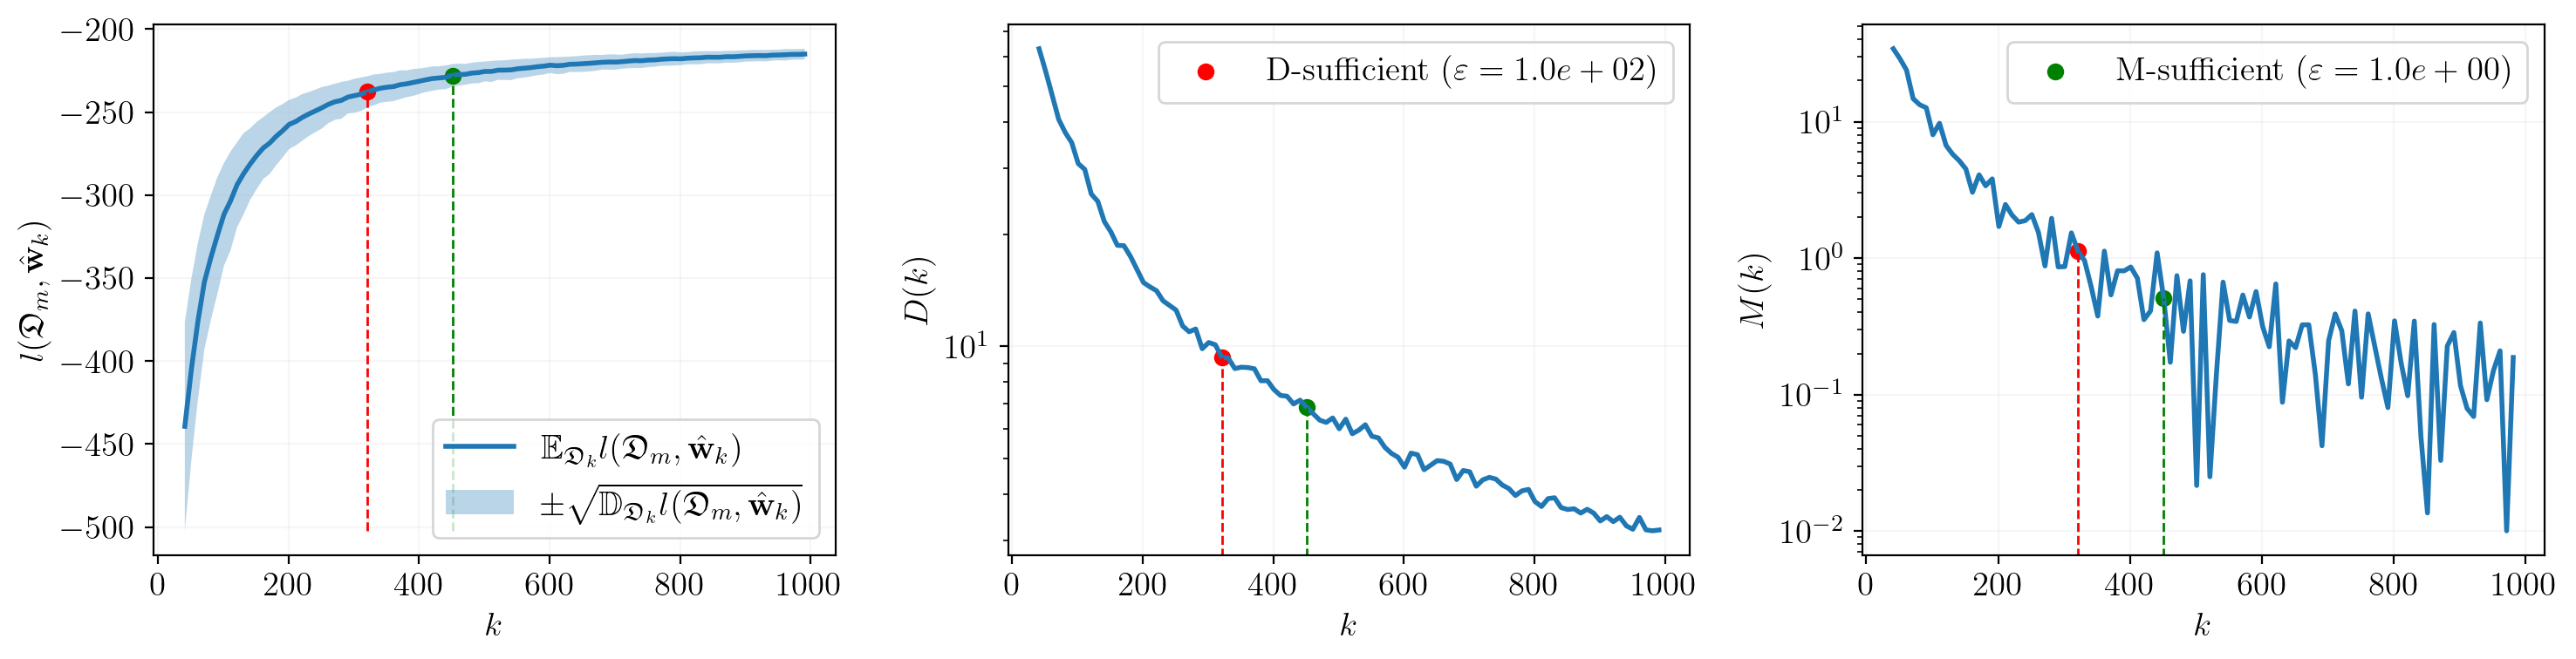

In [540]:
plot_bootstrap_sufficient(sample_sizes, llh_means, llh_vars, eps_variance=1e2, eps_rate=1e0, save=False, filename="synthetic-classification-sufficient.pdf")

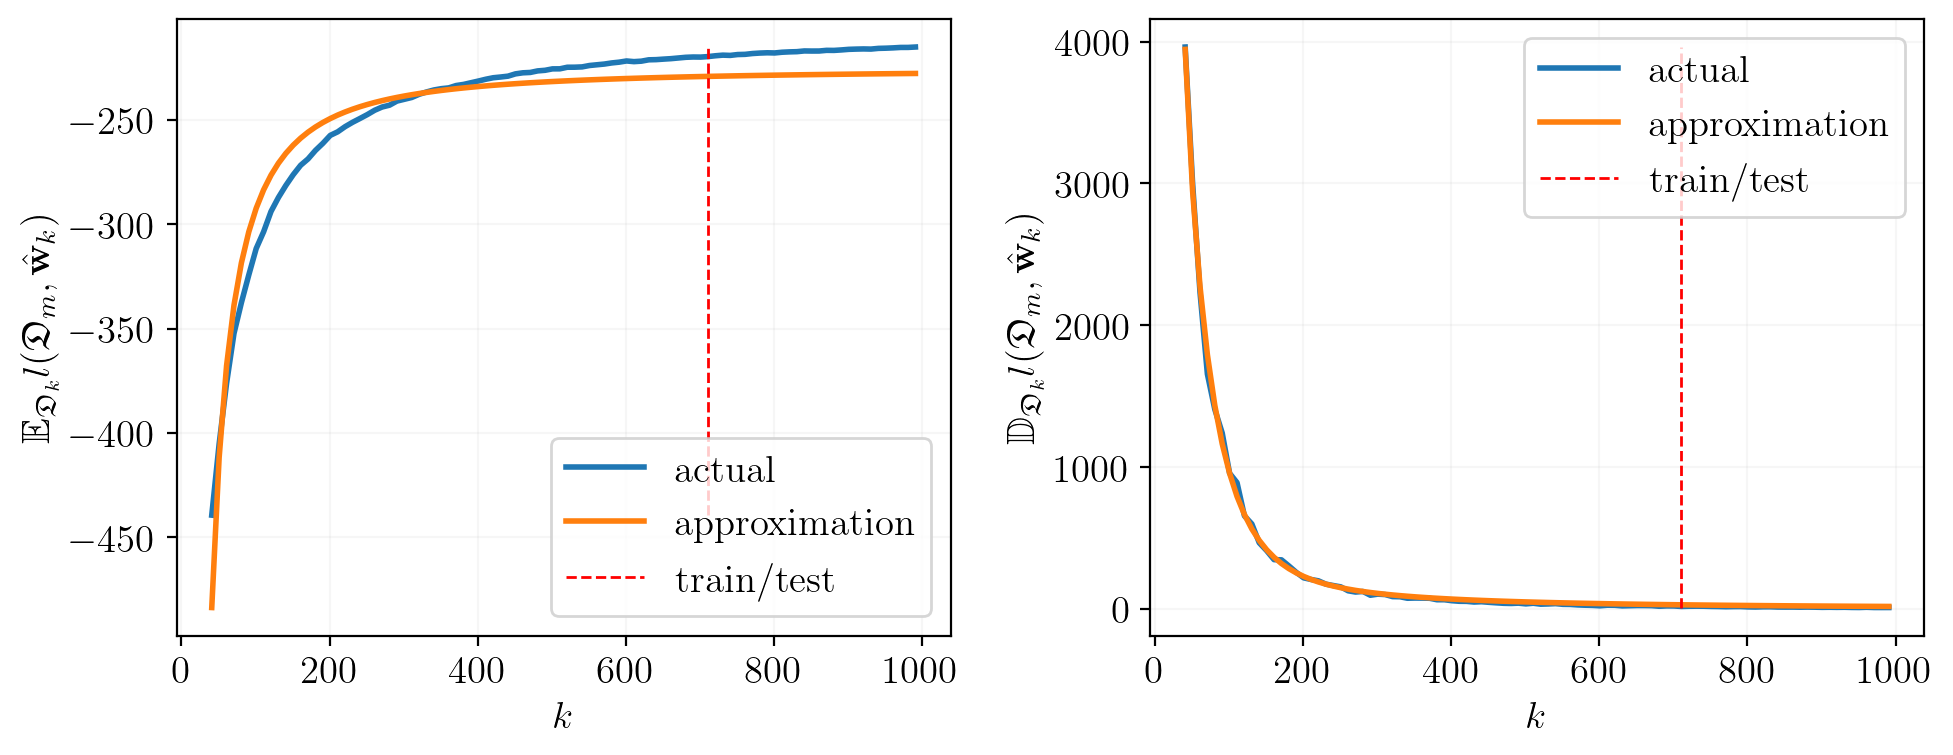

In [541]:
llh_means_approximation, llh_vars_approximation = approx(
    sample_sizes, sample_sizes, llh_means, llh_vars, func_mean_approx, func_var_approx
)

train_bound = int(0.7 * sample_sizes.size)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(sample_sizes, llh_means, label='actual')
ax1.plot(sample_sizes, llh_means_approximation, label='approximation')
ax1.vlines(sample_sizes[train_bound], min(llh_means), max(llh_means), colors='red', linestyle='dashed', linewidth=1, label='train/test')
ax1.legend()
ax1.set_xlabel(r"$k$")
ax1.set_ylabel(r"$\mathbb{E}_{\mathfrak{D}_k} l(\mathfrak{D}_m, \hat{\mathbf{w}}_k)$")

ax2.plot(sample_sizes, llh_vars, label='actual')
ax2.plot(sample_sizes, llh_vars_approximation, label='approximation')
ax2.vlines(sample_sizes[train_bound], min(llh_vars), max(llh_vars), colors='red', linestyle='dashed', linewidth=1, label='train/test')
ax2.legend()
ax2.set_xlabel(r"$k$")
ax2.set_ylabel(r"$\mathbb{D}_{\mathfrak{D}_k} l(\mathfrak{D}_m, \hat{\mathbf{w}}_k)$")

plt.tight_layout()
plt.savefig("synthetic-classification-approximation.pdf")
plt.show()

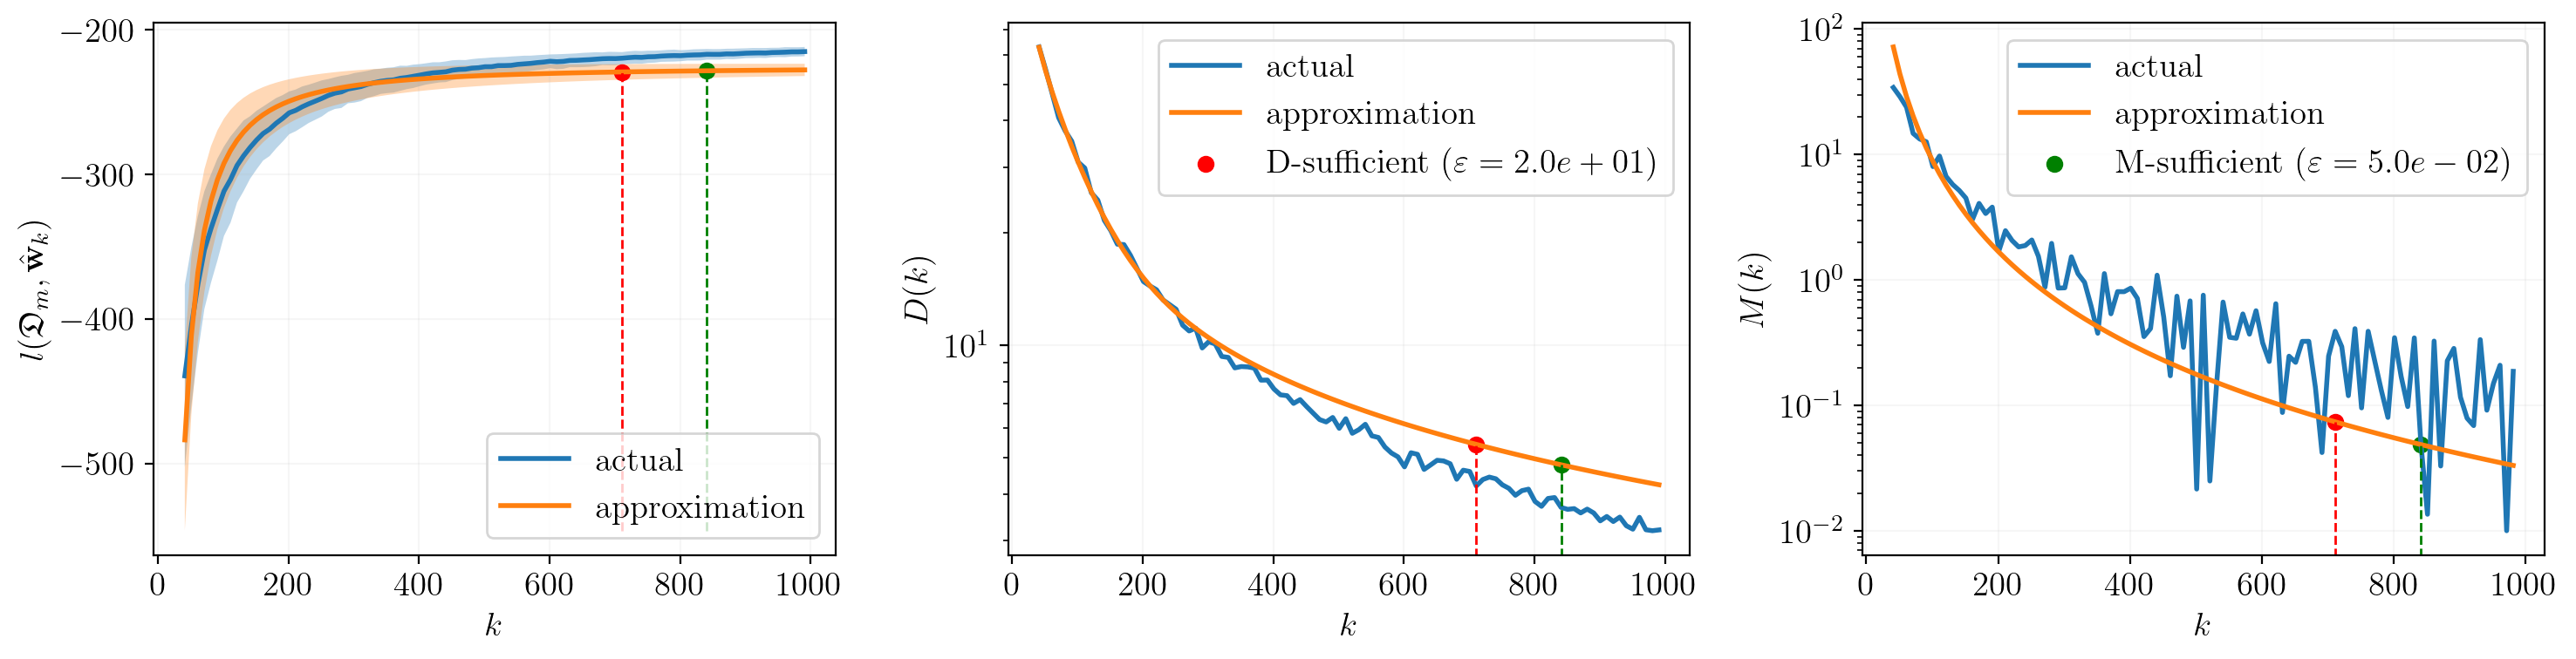

In [546]:
plot_bootstrap_sufficient_approximation(sample_sizes, llh_means, llh_means_approximation, llh_vars, llh_vars_approximation, eps_variance=2e1, eps_rate=5e-2, save=True, filename="synthetic-classification-approximation.pdf")